# Min/Max Range Estimation

Some of this notebook overlaps with the `station_selection.ipynb` file, but I wanted a seperate notebook to look specfically at what can be done for estimating ranges (both overall and seasonal/monthly/weekly) for the min and max temperature bounds.

## <p style="text-align: center; text-decoration:underline;">Table of Contents</p>

    
### [1: Station 87 (Pivot Table)](#station-87)

    - Examine station 87 by creating a pivot table that can be used to estimate daily/weekly/monthly parameters. See which combination best fits the data.
    
### [2: Absolute Value Estimation](#s87-yearly)

    - Examine using min/max values for estimating the overall min/max temperature allowed for an entire year.
    
### [2.1: Monthly Parameter Estimation](#s87-monthly)

    - Examine using temperature values for estimating the min/max temperature allowed for a specific month, spanning over an entire year. This is done through quantile filtering, and a threshold is applied.
    
### [3. Day/Night Monthly Ranges](#s87-cycle)

    - Examine setting different min/max bounds based on the time of day (day/night cycle). Similar methods applied from previous section, but data is split based on time (day: 6am - 9pm, night: 9pm-6am).

In [1]:
# import general libraries for data exploration and cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import seaborn as sns
import datetime as dt
%matplotlib inline

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

# Import libraries for sql connection
import mysql.connector
import pickle
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load credentials for login (hidden and not added to repo)
with open("login_cred.pkl", "rb") as fp:
    config = pickle.load(fp)
    print('Credentials Loaded')
    
cnx = mysql.connector.connect(**config) # connection point

Credentials Loaded


In [3]:
# Query DB to get timestamp and temp data for top 5 stations above
top5_q = ("""SELECT station_id, tstamp, temp
            FROM raw_awn_records r
            WHERE r.station_id IN (115, 152, 87, 36, 111) """)

s_top_5 = pd.read_sql(top5_q, cnx)

## Station 87 (Pivoting Example) <a class="anchor" id="station-87"></a>

Below is an example of creating a pivot table, where each row is a day for that station, each column is a 15 minute interval, and the values are temperature readings.
    
- **NOTE 1: Applying the threshold of standard deviation on the estimated min/max is based on confidence intervals. This is assuming that the data is normally distributed, which for the most part it seemed to be (refer to 2x2 graph of daily min/max/avg with standard deviation lines.**

- *NOTE 2:* We will also want to look at filtering for only using a subset of years (i.e. one previous, two previous, etc.) to figure out how this changes the accuracy of parameter estimation. This will help figure out how much data is needed to be collected before parameters can be estimated (not just for min/max, but also variation).

In [4]:
s_top_5

,station_id,tstamp,temp
0,87,2014-01-01 00:00:00,38.3
1,87,2014-01-01 00:15:00,38.4
2,87,2014-01-01 00:30:00,38.3
3,87,2014-01-01 00:45:00,37.9
4,87,2014-01-01 01:00:00,37.1
...,...,...,...
345480,87,2023-11-08 18:00:00,48.0
345481,87,2023-11-08 18:15:00,47.6
345482,87,2023-11-08 18:30:00,45.8
345483,87,2023-11-08 18:45:00,45.6


In [4]:
# Subset data
s87 = s_top_5[s_top_5.station_id == 87]

# Convert tstamp to date and time
s87[['date', 'time']] = [str(x).split('T') for x in s87.tstamp.values]

# Clean up time column
s87['time'] = [x.split('.')[:1][0] for x in s87.time.values]

# Drop unused columns
s87 = s87.drop(['station_id', 'tstamp'], axis=1)

# Pivot with index being date (single day), columns being 24 hour period, values being temp reading
s87_pivot = s87.pivot(index='date', columns='time', values='temp')

# Reset index
s87_pivot.reset_index(inplace=True)

# Set index to be date and remove column name
s87_pivot = s87_pivot.set_index('date')

s87_pivot = s87_pivot.rename_axis(index=None)

# Show pivot table
s87_pivot.head()

time,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
2014-01-01,38.3,38.4,38.3,37.9,37.1,37.3,37.3,36.2,36.1,35.5,...,32.5,32.6,32.6,32.5,32.5,32.3,32.3,32.2,32.2,32.1
2014-01-02,32.0,32.0,31.8,31.7,31.7,31.6,31.5,31.5,31.5,31.5,...,36.0,36.4,38.8,39.5,42.1,45.3,47.0,47.6,51.9,53.8
2014-01-03,52.8,50.9,49.1,48.9,48.6,48.1,47.0,46.1,45.4,44.4,...,38.7,37.7,37.4,36.8,37.1,36.5,36.1,35.5,36.5,35.3
2014-01-04,34.6,33.9,34.2,33.3,33.1,33.0,32.7,32.2,31.8,31.3,...,30.9,30.5,30.3,29.9,29.8,30.2,29.6,29.4,28.8,28.8
2014-01-05,28.4,28.4,27.9,27.7,28.1,27.7,27.2,27.2,27.0,26.5,...,29.3,29.2,29.2,29.1,27.6,27.7,28.1,28.2,28.2,27.5


## Absolute Value Estimation <a class="anchor" id="s87-yearly"></a>

Below looks at using the daily average temperature in order to estimate parameters (min/max temperature) that can be implemented for a full year (i.e. **overall min/max ranges**). We produce confidence intervals around the daily average min/max temperatures in order to determine bounds that can applied to catch outliers. The years 2014-2022 are used to estimating the min/max values, and 2023 is utilized to validate if the estimated parameters would hold.

### Single Overall Bounds

Below looks at creating a single overall bounds, ignoring considering what month or season it falls under. 

In [5]:
s87_pivot_e = s87_pivot.iloc[:3287, :] # pull all data from 2014 - 2023
s87_pivot_v = s87_pivot.iloc[3287:, :] # pull all data from 2023 - end

In [6]:
# Get the daily max and min temperatures for each day
daily_min = s87_pivot_e.min(axis=1, skipna=True).values
daily_max = s87_pivot_e.max(axis=1, skipna=True).values
daily_avg = s87_pivot_e.mean(axis=1, skipna=True).values

# Get the standard deviation for each
min_std = np.nanstd(daily_min)
max_std = np.nanstd(daily_max)
avg_std = np.nanstd(daily_avg)

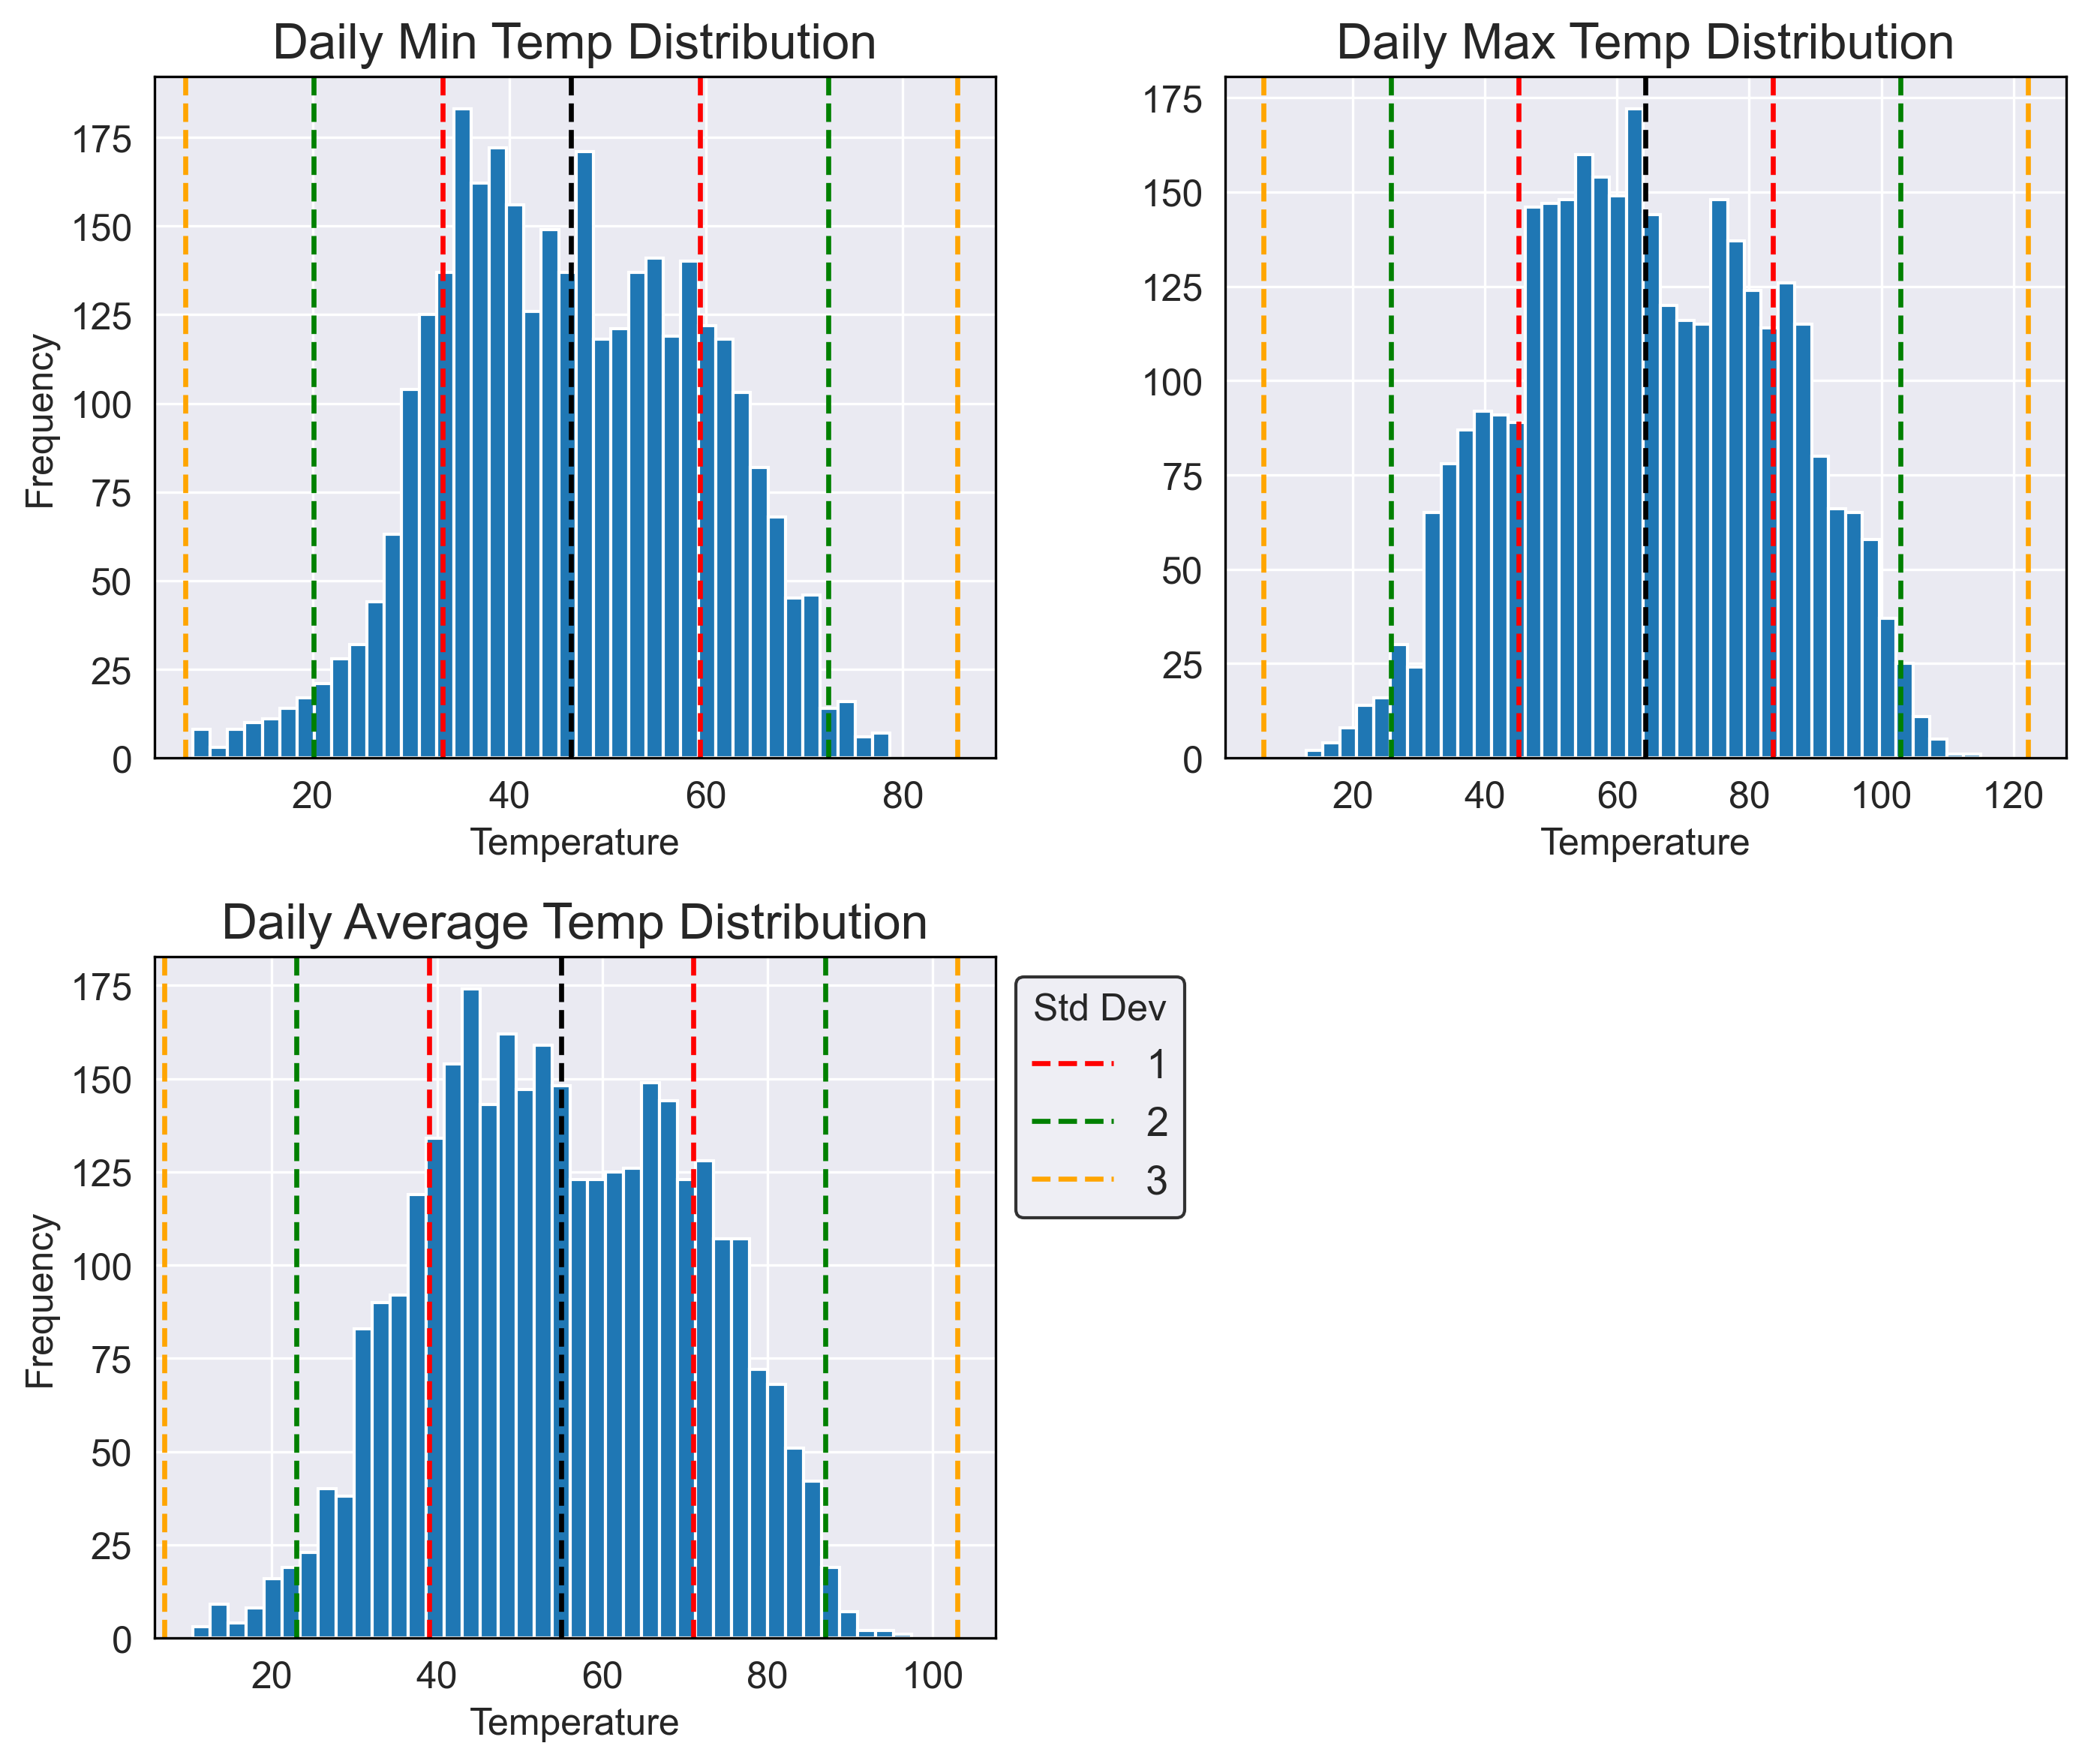

In [7]:
# Subplots of temperature values
fig, axs = plt.subplots(2, 2, figsize=(9.5,8))
fig.delaxes(axs[1, 1])
axs = axs.flatten()
colors = plt.get_cmap('tab10').colors

# Create histogram of daily min temperature
axs[0].hist(daily_min, bins=40)
axs[0].set_title('Daily Min Temp Distribution')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Temperature')

# Plot average, and confidence interval values for daily min
axs[0].axvline(np.nanmean(daily_min), color='black', linestyle='--', linewidth=1.6)
for i, c in zip(range(1,4), ['red', 'green', 'orange']):
    axs[0].axvline(np.nanmean(daily_min) + min_std * i, color=c, linestyle='--', linewidth=1.6)
    axs[0].axvline(np.nanmean(daily_min) - min_std * i, color=c, linestyle='--', linewidth=1.6)

# Create histogram of daily min temperature
axs[1].hist(daily_max, bins=40)
axs[1].set_title('Daily Max Temp Distribution')
axs[1].set_xlabel('Temperature')

# Plot average, and confidence interval values for daily min
axs[1].axvline(np.nanmean(daily_max), color='black', linestyle='--', linewidth=1.6)
for i, c in zip(range(1,4), ['red', 'green', 'orange']):
    axs[1].axvline(np.nanmean(daily_max) + max_std * i, color=c, linestyle='--', linewidth=1.6, label=i)
    axs[1].axvline(np.nanmean(daily_max) - max_std * i, color=c, linestyle='--', linewidth=1.6)
    
# Create histogram of daily min temperature
axs[2].hist(daily_avg, bins=40)
axs[2].set_title('Daily Average Temp Distribution')
axs[2].set_xlabel('Temperature')
axs[2].set_ylabel('Frequency')

# Plot average, and confidence interval values for daily min
axs[2].axvline(np.nanmean(daily_avg), color='black', linestyle='--', linewidth=1.6)
for i, c in zip(range(1,4), ['red', 'green', 'orange']):
    axs[2].axvline(np.nanmean(daily_avg) + avg_std * i, color=c, linestyle='--', linewidth=1.6, label=i)
    axs[2].axvline(np.nanmean(daily_avg) - avg_std * i, color=c, linestyle='--', linewidth=1.6)

# Add legend for standard deviation values
axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Std Dev')
plt.tight_layout()
plt.show()

The below parameters are what would be estimated when looking at the daily average values, then taking a number of standard deviations above this value. This can also be used to eliminate extreme outliers as our confidence interval would not capture these values (i.e. if 130 appeared for some reason, it would get flagged as above the max bound). A slight threshold could also be applied so that if it is slightly over the allowed value, it won't get flagged (such as bound $\pm$ 3 degrees).

In [8]:
# IGNORE THIS CODE (just used to label graph by month)
s_87_labels = s87.copy() # create copy (only used for labels)
s_87_labels[['year', 'month', 'day']] = [x.split('-') for x in s_87_labels.date.values] # create 3 features
s_87_labels = s_87_labels[s_87_labels.year == '2023'] # select 2023
s_87_labels.reset_index(inplace=True) # reset index
s_87_labels['month'] = s_87_labels['month'].astype(int) # month: str -> int
month_idx = s_87_labels.index[s_87_labels['month'].diff() != 0].values # index values of month
month_vals = np.unique(s_87_labels.month) # list of months

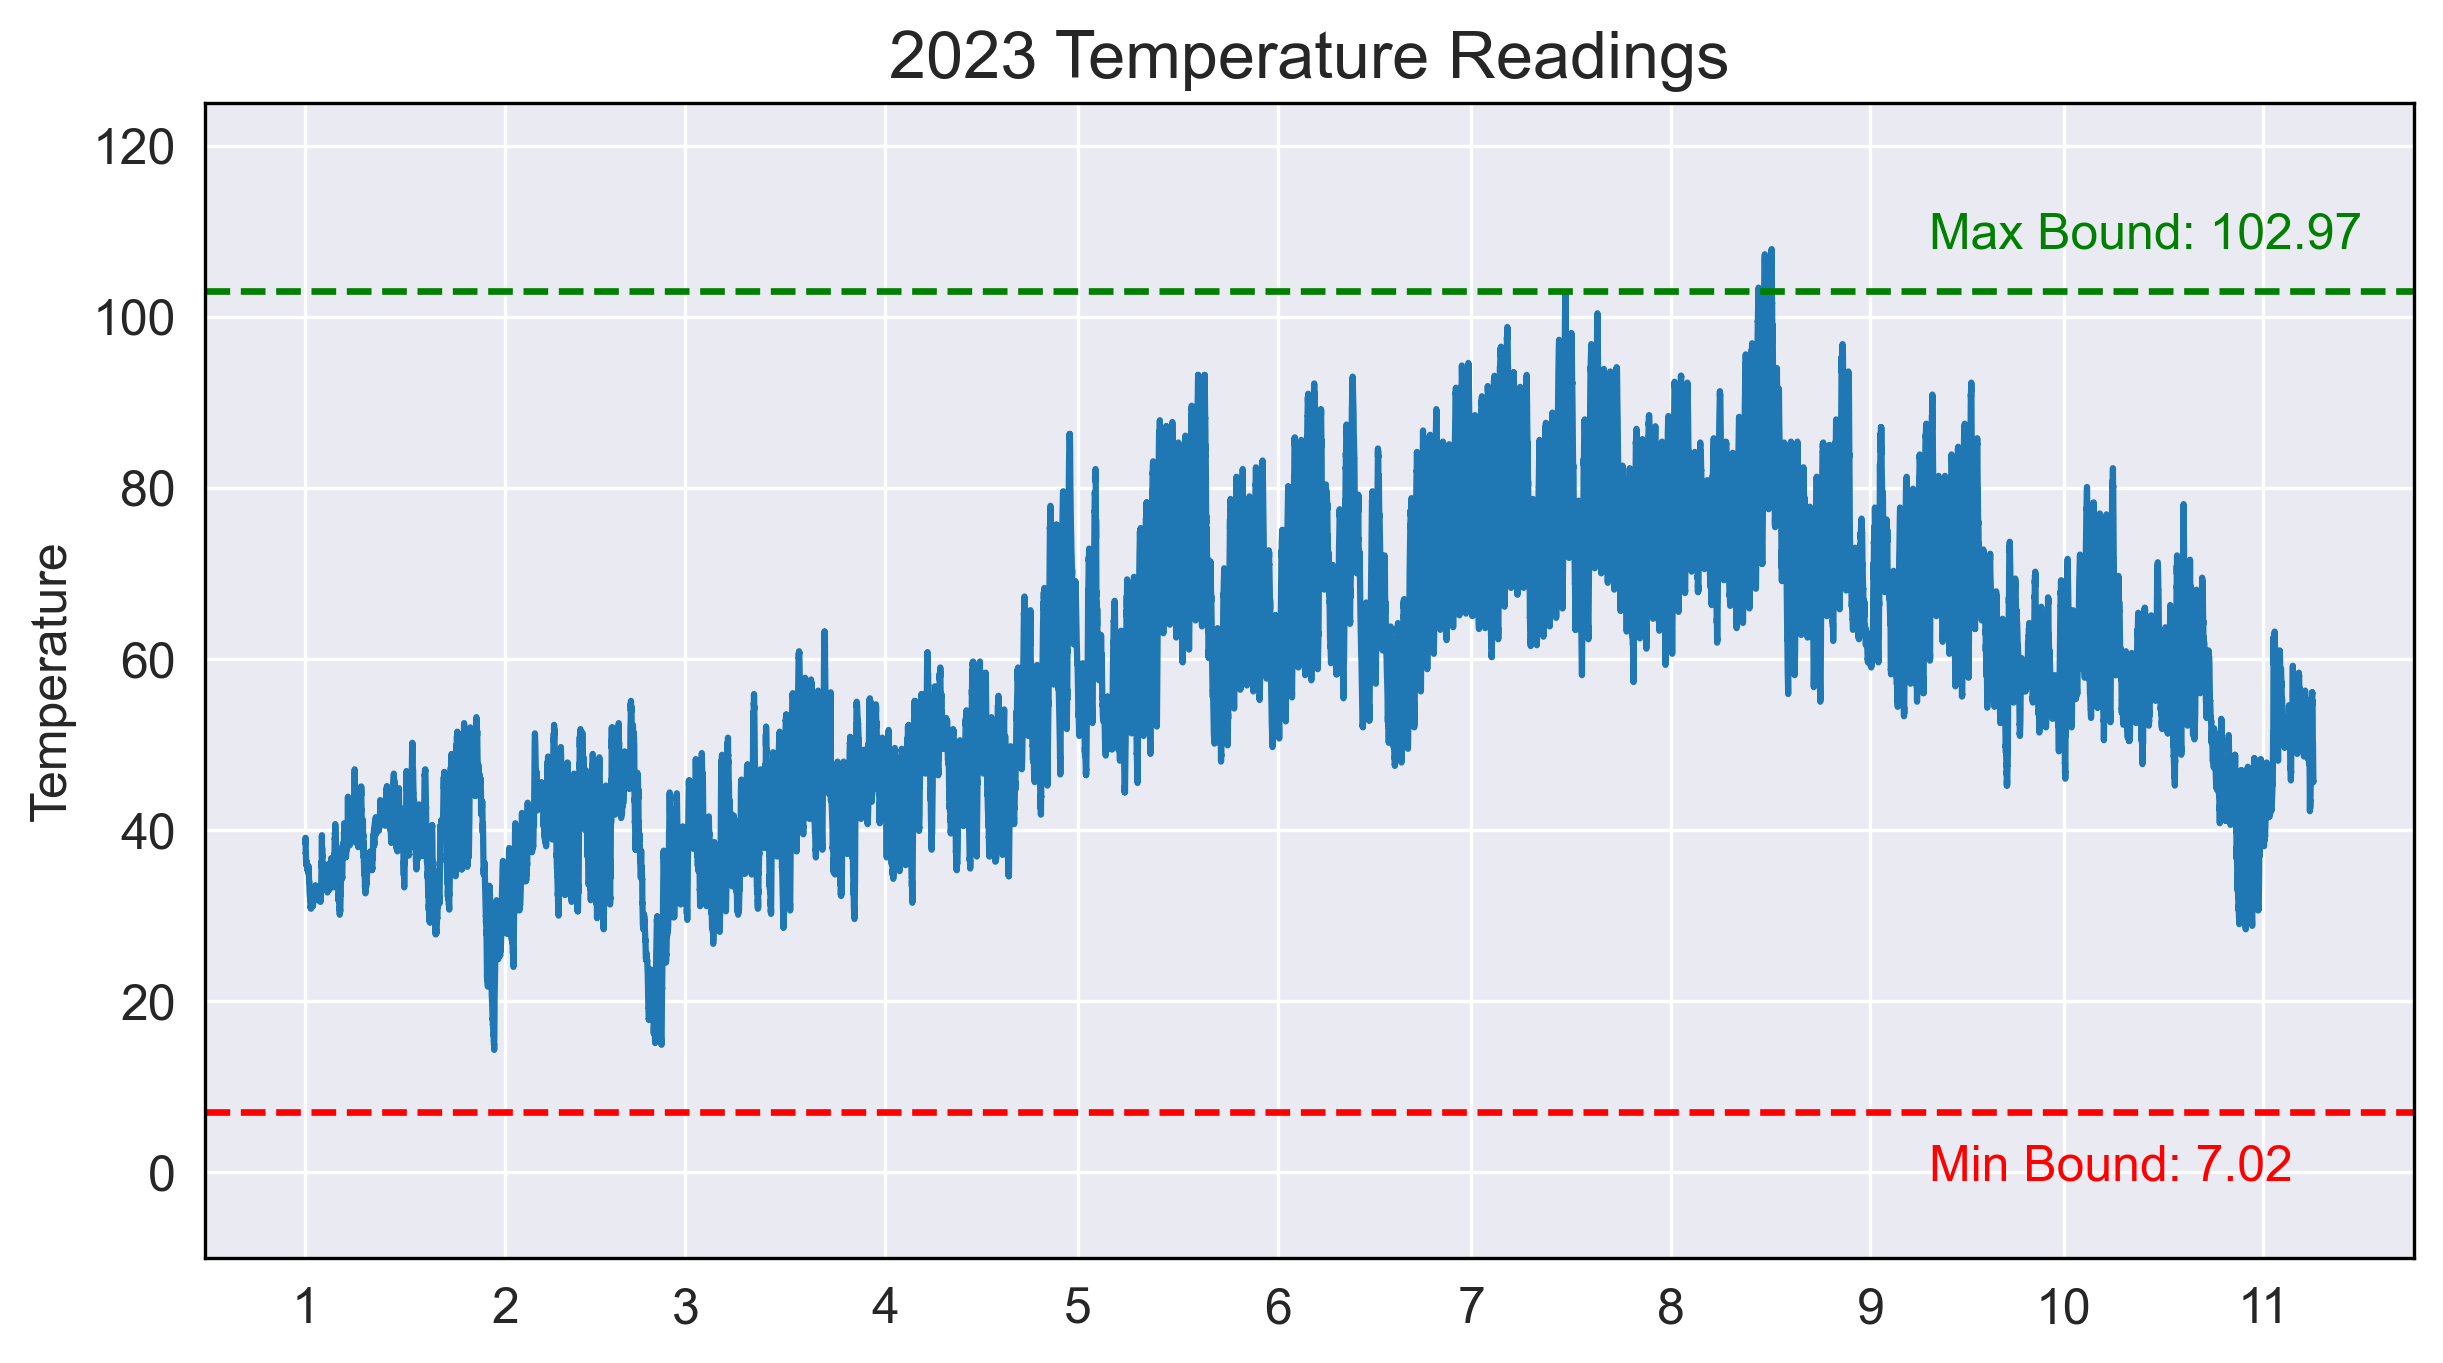

In [9]:
n_std = 3 # set number of standard dev (data captured: 1 - 68%, 2 - 95%, 3 - 99%)

low_bound = round(np.nanmean(daily_avg) - n_std * avg_std, 2)
high_bound = round(np.nanmean(daily_avg) + n_std * avg_std, 2)

# Create plot for single month
plt.figure(figsize=(9.5,5))
plt.plot(s87_pivot_v.values.flatten())
plt.title('2023 Temperature Readings')
plt.ylabel('Temperature')
plt.axhline(low_bound, color='r', linestyle='--', linewidth=1.6)
plt.text(24200, low_bound-8, f"Min Bound: {low_bound}", color='r')
plt.axhline(high_bound, color='g', linestyle='--', linewidth=1.6)
plt.text(24200, high_bound+5, f"Max Bound: {high_bound}", color='g')
plt.ylim(-10, 125)
plt.xticks(month_idx, month_vals)

plt.show();

The above graph represents the 2023 data for temperature readings, with bound parameters on the min/max temperature values being estimated by the 2014-2022 temperature readings. The number of standard deviations can be altered in the cell, and then the graph will be updated to change the estimated min/max values. Some takeaways at the moment:

- Using 2 standard deviations (95% of the data captured within confidence interval) would mark values that do not seem to be abnormal as being too hot or too cold.
- Using 3 standard deviations (99% of data captured) would not mark any values, but the estimated paramters are very generous (high temp is 122 degrees - this is a bit high for what we would expect).

### Monthly Parameter Estimation <a class="anchor" id="s87-monthly"></a>

Below looks at using the temperature readings to estimate parameters for the ranges of the min/max values for each month. The difference from the last section is that each months daily average will be used to estimate a particular month instead of creating a single overall value for each (i.e. each parameter will have 12 values - one for each month). This is done by filtering the data using quantiles (i.e. picking values that capture a certain percent of data above for the min, and below for the max). This will eliminate any extreme outliers in previous years, and a threshold can be applied (in this case standard deviation) to allow for some tolerance.

In [10]:
# Get the daily max and min temperatures for each day
daily_min = s87_pivot_e.min(axis=1, skipna=True).values
daily_max = s87_pivot_e.max(axis=1, skipna=True).values

In [11]:
tmp = [int(x.split('-')[1]) for x in s87_pivot_e.index.values] # get month values
tmp_idx = [x for x in range(1, len(tmp)) if tmp[x] != tmp[x-1]] # get month index
tmp_idx[:0] = [0] # append start idx
tmp_idx.append(len(daily_min)-1) # append end idx

In [12]:
# Set quantile filter value. This will be:
## quantile_percent below the max value (i.e. 95% of data below this max value)
## quantile_percent above the min value (i.e. 95% of data above this min value)
quantile_percent = 0.95

# Create lists to hold monthly min/max and their std dev
monthly_min = []
min_std = []
monthly_max = []
max_std = []

for x in range(1, len(tmp_idx)):
    fd = tmp_idx[x-1] # get first day of month idx
    ld = tmp_idx[x] # get last day of month idx
    monthly_min.append(np.nanquantile(daily_min[fd:ld], 1-quantile_percent)) # find min for the month 
    monthly_max.append(np.nanquantile(daily_max[fd:ld], quantile_percent)) # find max for the month
    min_std.append(np.nanstd(daily_min[fd:ld])) # find monthly min std dev
    max_std.append(np.nanstd(daily_max[fd:ld])) # find monthly max std dev

In [13]:
n_years = int(len(monthly_max)/12) # get number of years

# Reshape each array so that it has 12 values per row (each row is a year, each column is a month)
# Then take column average so that you get the average 12 values (avg tmp and avg std dev)
monthly_min_est = np.mean(np.array(monthly_min).reshape(n_years,12), axis=0)
monthly_min_std = np.mean(np.array(min_std).reshape(n_years,12), axis=0)
monthly_max_est = np.mean(np.array(monthly_max).reshape(n_years,12), axis=0)
monthly_max_std = np.mean(np.array(max_std).reshape(n_years,12), axis=0)

In [14]:
m_idx = month_idx.copy() # copy month index of 2023 temp values
m_idx = np.append(m_idx, len(s87_pivot_v.values.flatten())) # append end idx for lines

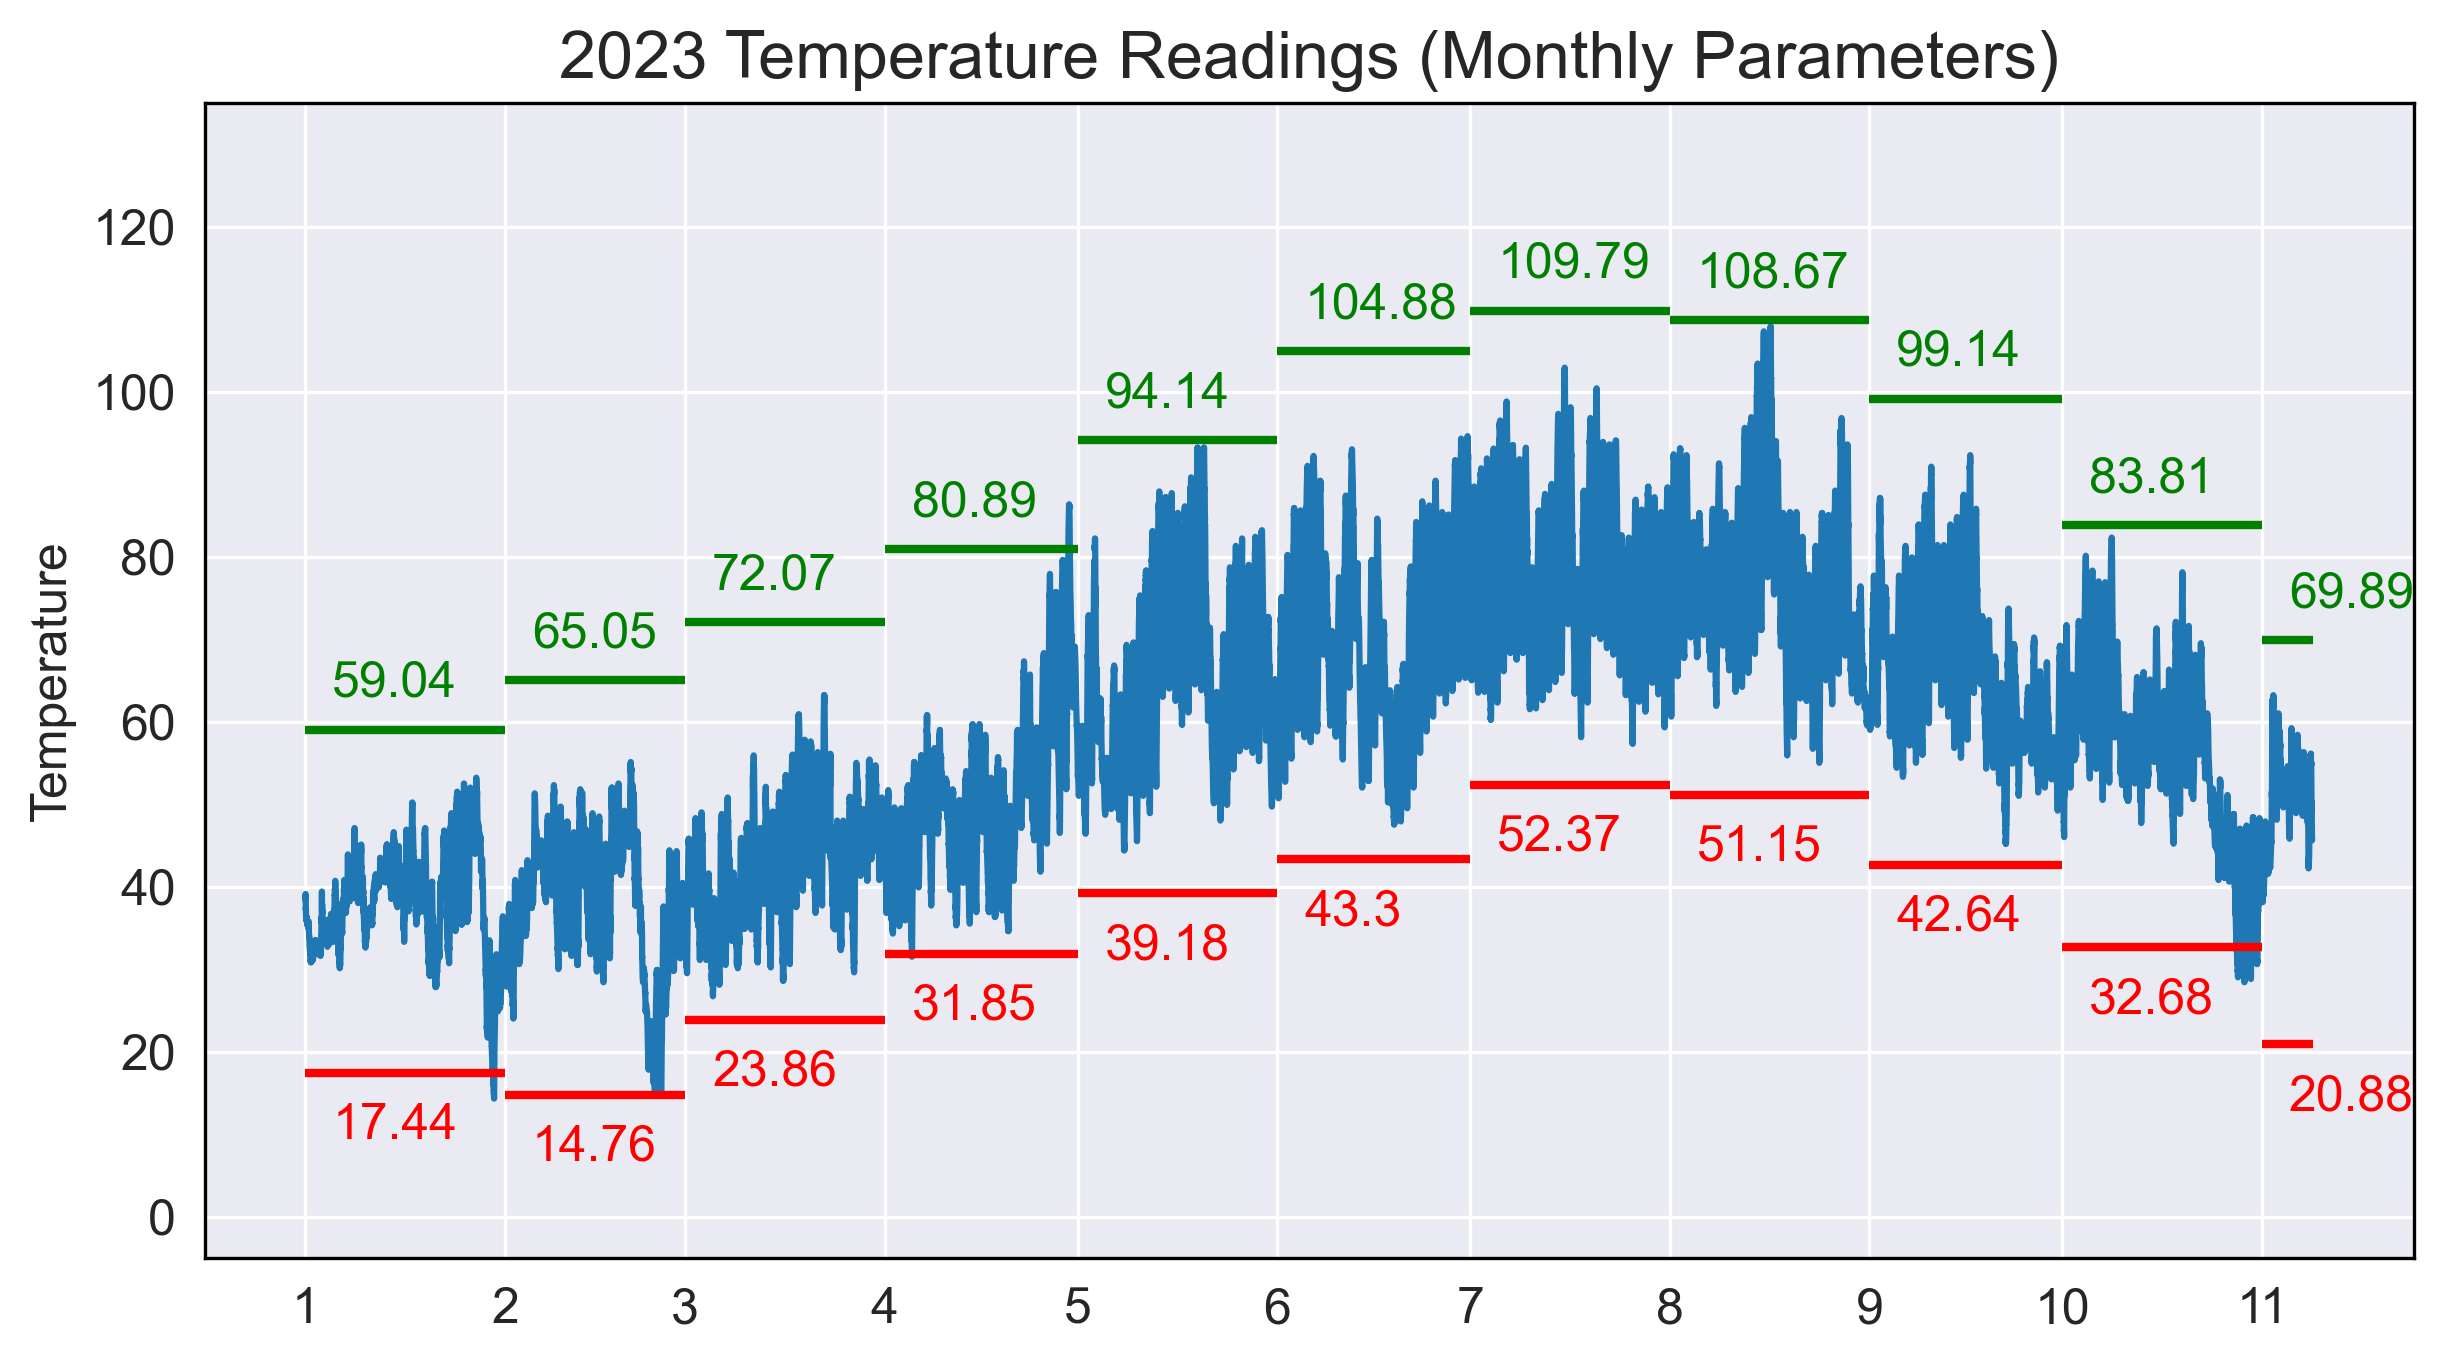

In [15]:
n_std = 1 # set number of standard dev (this is more of just a threshold)

# Get low and high temp bounds for each month (12 values)
low_bounds = np.round(monthly_min_est - n_std * monthly_min_std, 2)
high_bounds = np.round(monthly_max_est + n_std * monthly_max_std, 2)

# Create plot for single month
plt.figure(figsize=(9.5,5))
plt.plot(s87_pivot_v.values.flatten())
plt.title('2023 Temperature Readings (Monthly Parameters)')
plt.ylabel('Temperature')
for i in range(1, len(m_idx)):
    plt.hlines(low_bounds[i-1], m_idx[i-1], m_idx[i], color='r', linestyle='solid', linewidth=2)
    plt.hlines(high_bounds[i-1], m_idx[i-1], m_idx[i], color='g', linestyle='solid', linewidth=2)
    plt.text(m_idx[i-1]+400, low_bounds[i-1]-8, str(low_bounds[i-1]), color='r')
    plt.text(m_idx[i-1]+400, high_bounds[i-1]+4, str(high_bounds[i-1]), color='g')
plt.ylim(-5, 135)
plt.xticks(month_idx, month_vals)

plt.show();

The above graphs shows the estimated min/max (overall) values for each month, based on the previous 10 years. The filtering seems to work well, with the current bounds checking temperature that would be appropriate for that month (i.e. in winter, the max is around 60-70 degrees where as during the summer it is near 100. Similar follows for the minimum).

## Day/Night Monthly Ranges <a class="anchor" id="s87-cycle"></a>

Below we will look at estimating the max ranges for day/night, for each month. This will be similar to the above, but will have two seperate graphs (with different defined ranges) for day/night cycle. We will define the following based on the checks provided in the README.md file:
- Day: 10:00 - 22:00
- Night: 22:00 - 10:00

In [154]:
s87_cycle = s87_pivot.copy() # Create copy

cols = s87_cycle.columns.tolist() # select all column names
dn_order = cols[40:81] +cols[85:] + cols[:40] # re-order

s87_cycle = s87_cycle[dn_order] # reorder columns to be day/night cycle, Day - [:53], Night - [53:]

In [155]:
s87_pivot_e = s87_cycle.iloc[:3287, :] # pull all data from 2014 - 2023
s87_pivot_v = s87_cycle.iloc[3287:, :] # pull all data from 2023 - end

In [161]:
# Seperate into day/night cycles
s87_pivot_e_day = s87_pivot_e.iloc[:, :45]
s87_pivot_v_day = s87_pivot_v.iloc[:, :45]
s87_pivot_e_night = s87_pivot_e.iloc[:, 45:]
s87_pivot_v_night = s87_pivot_v.iloc[:, 45:]

In [162]:
# Get the daily max and min temperatures for each day, day and night
daily_min_d = s87_pivot_e_day.min(axis=1, skipna=True).values
daily_max_d = s87_pivot_e_day.max(axis=1, skipna=True).values
daily_min_n = s87_pivot_e_night.min(axis=1, skipna=True).values
daily_max_n = s87_pivot_e_night.max(axis=1, skipna=True).values

In [163]:
tmp = [int(x.split('-')[1]) for x in s87_pivot_e_day.index.values] # get month values
tmp_idx = [x for x in range(1, len(tmp)) if tmp[x] != tmp[x-1]] # get month index
tmp_idx[:0] = [0] # append start idx
tmp_idx.append(len(daily_min_d)-1) # append end idx

In [164]:
# Set quantile filter value. This will be:
## quantile_percent below the max value (i.e. 95% of data below this max value)
## quantile_percent above the min value (i.e. 95% of data above this min value)
quantile_percent = 0.95

# Create lists to hold monthly min/max and their std dev (for day and night)
monthly_day_min = []
min_day_std = []
monthly_day_max = []
max_day_std = []

monthly_night_min = []
min_night_std = []
monthly_night_max = []
max_night_std = []

for x in range(1, len(tmp_idx)):
    fd = tmp_idx[x-1] # get first day of month idx
    ld = tmp_idx[x] # get last day of month idx
    monthly_day_min.append(np.nanquantile(daily_min_d[fd:ld], 1-quantile_percent)) # find min for the month 
    monthly_day_max.append(np.nanquantile(daily_max_d[fd:ld], quantile_percent)) # find max for the month
    min_day_std.append(np.nanstd(daily_min_d[fd:ld])) # find monthly min std dev
    max_day_std.append(np.nanstd(daily_max_d[fd:ld])) # find monthly max std dev
    
    monthly_night_min.append(np.nanquantile(daily_min_n[fd:ld], 1-quantile_percent)) # find min for the month 
    monthly_night_max.append(np.nanquantile(daily_max_n[fd:ld], quantile_percent)) # find max for the month
    min_night_std.append(np.nanstd(daily_min_n[fd:ld])) # find monthly min std dev
    max_night_std.append(np.nanstd(daily_max_n[fd:ld])) # find monthly max std dev

In [165]:
n_years = int(len(monthly_day_max)/12) # get number of years

# Reshape each array so that it has 12 values per row (each row is a year, each column is a month)
# Then take column average so that you get the average 12 values (avg tmp and avg std dev)
monthly_min_day_est = np.mean(np.array(monthly_day_min).reshape(n_years,12), axis=0)
monthly_min_day_std = np.mean(np.array(min_day_std).reshape(n_years,12), axis=0)
monthly_max_day_est = np.mean(np.array(monthly_day_max).reshape(n_years,12), axis=0)
monthly_max_day_std = np.mean(np.array(max_day_std).reshape(n_years,12), axis=0)

monthly_min_night_est = np.mean(np.array(monthly_night_min).reshape(n_years,12), axis=0)
monthly_min_night_std = np.mean(np.array(min_night_std).reshape(n_years,12), axis=0)
monthly_max_night_est = np.mean(np.array(monthly_night_max).reshape(n_years,12), axis=0)
monthly_max_night_std = np.mean(np.array(max_night_std).reshape(n_years,12), axis=0)

#### Day Range Estimation

In [166]:
tmp = [int(x.split('-')[1]) for x in s87_pivot_v_day.index.values] # get month from index
m_idx = [x*len(s87_pivot_v_day.columns.tolist()) for x in range(1,len(tmp)) if tmp[x] != tmp[x-1]] # find where month changes
m_idx.insert(0, 0) # insert start date
m_idx.append(len(s87_pivot_v_day.values.flatten())) # insert end date

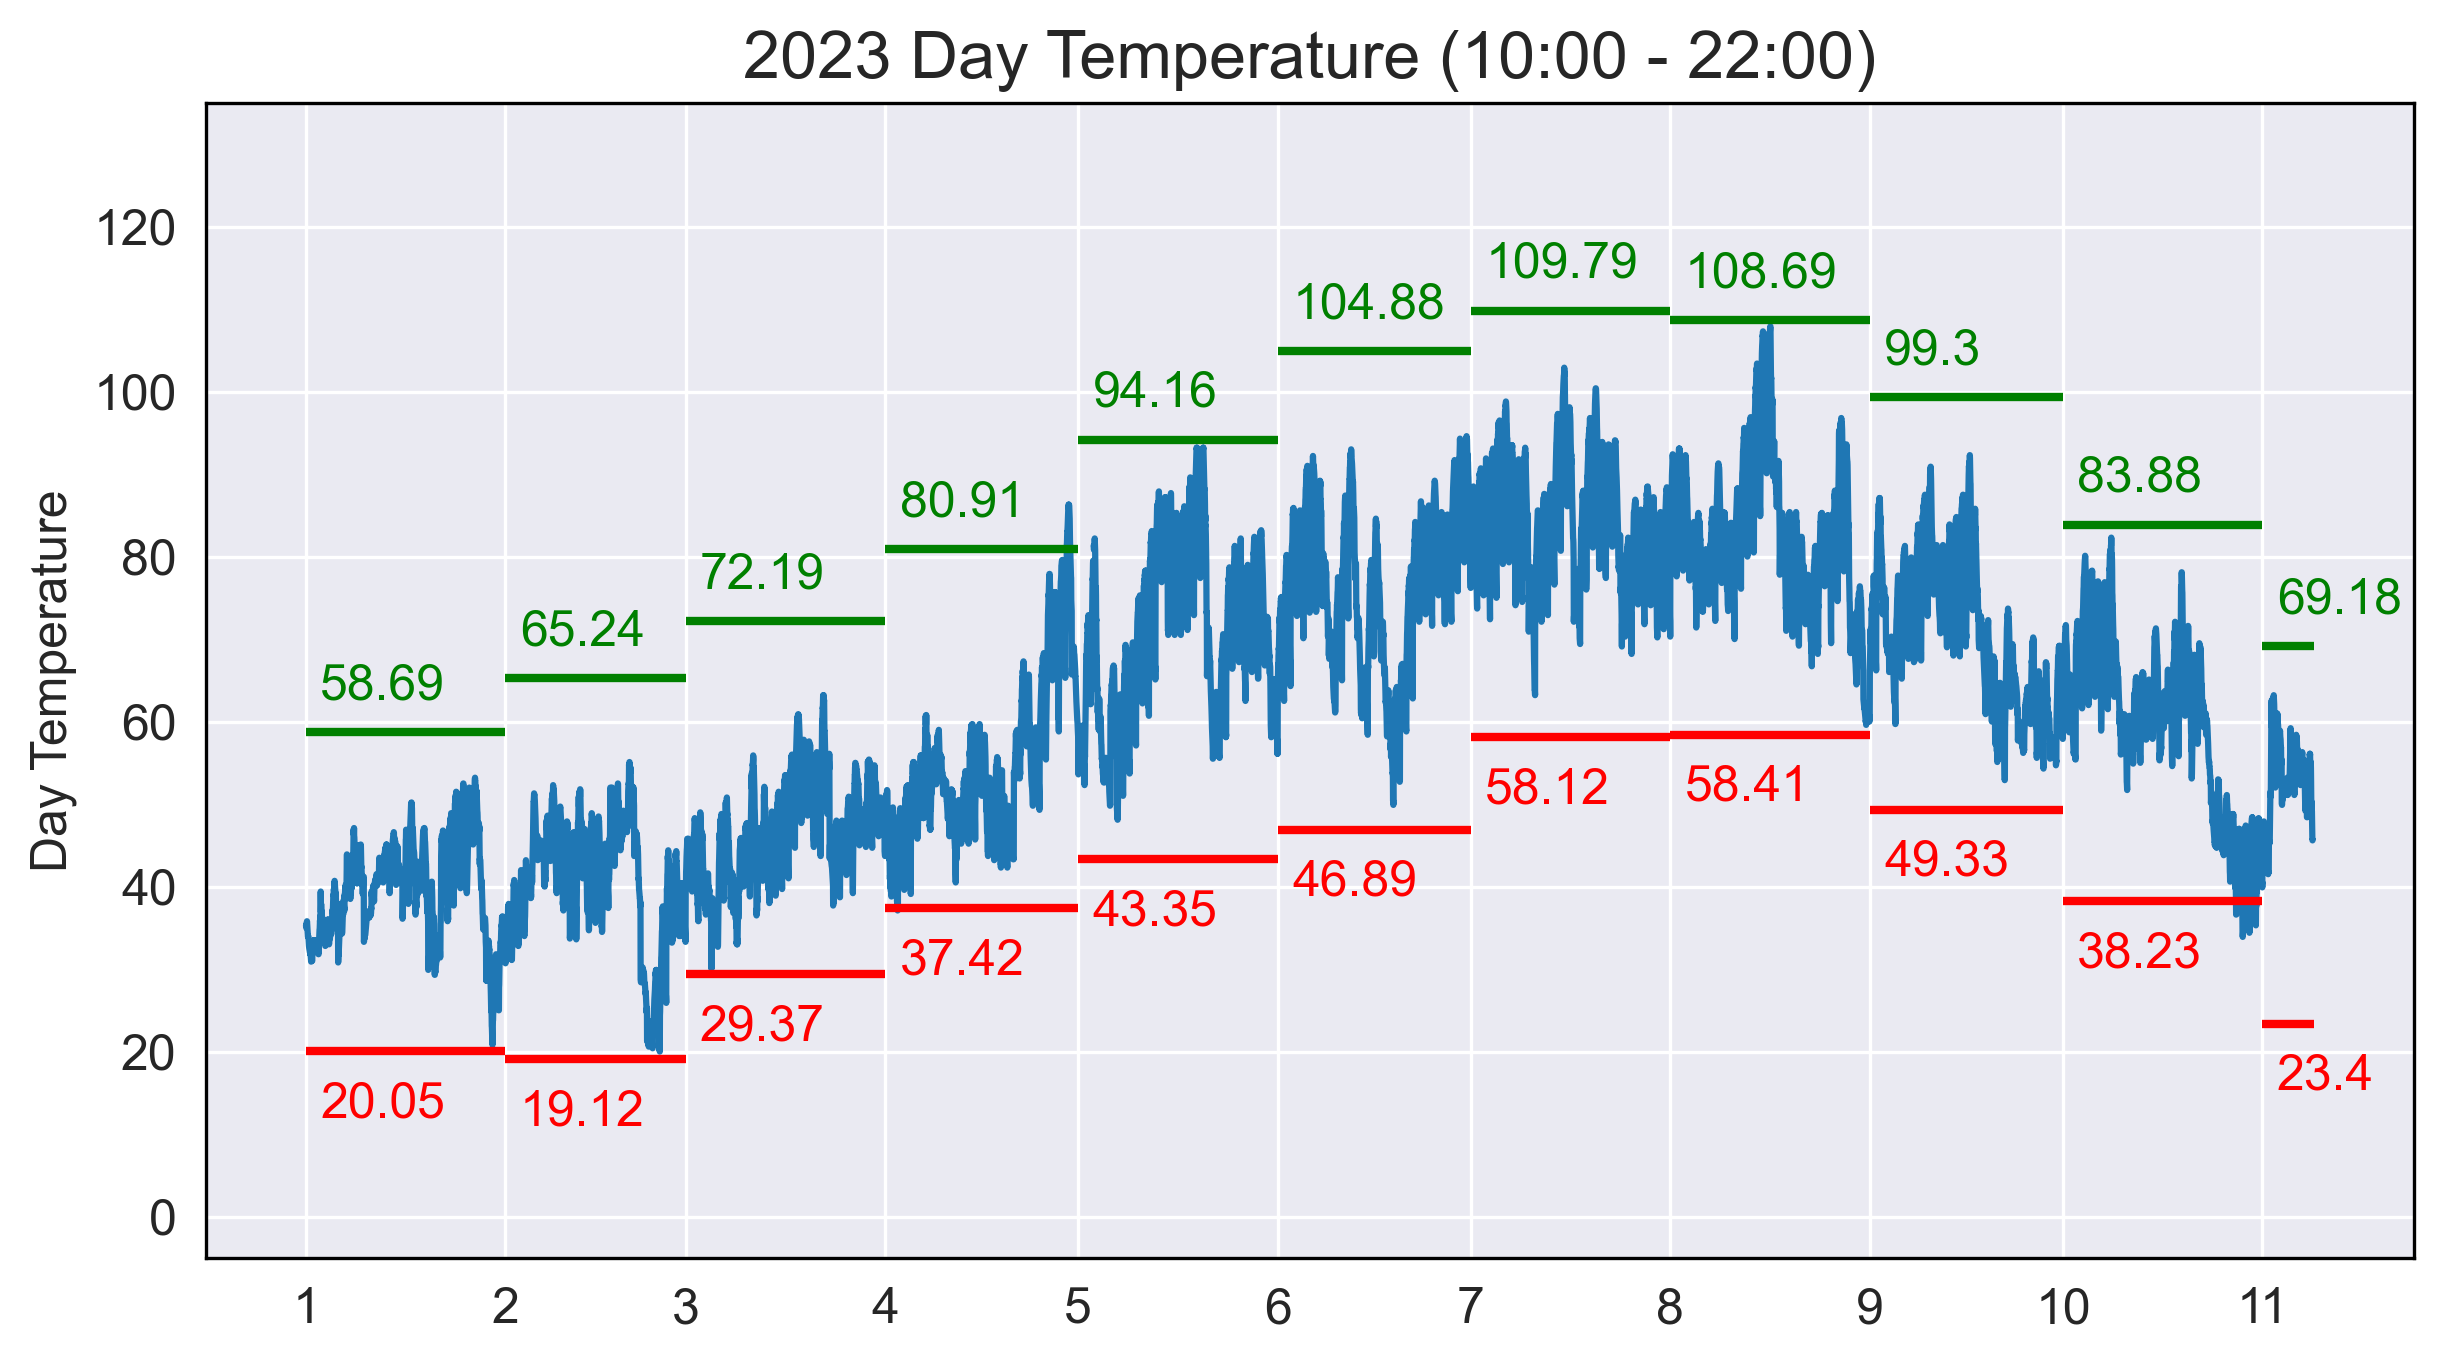

In [167]:
n_std = 1 # set number of standard dev (this is more of just a threshold)

# Get low and high temp bounds for each month (12 values)
low_bounds = np.round(monthly_min_day_est - n_std * monthly_min_day_std, 2)
high_bounds = np.round(monthly_max_day_est + n_std * monthly_max_day_std, 2)

# Create plot for single month
plt.figure(figsize=(9.5,5))
plt.plot(s87_pivot_v_day.values.flatten())
plt.title('2023 Day Temperature (10:00 - 22:00)')
plt.ylabel('Day Temperature')
for i in range(1, len(m_idx)):
    plt.hlines(low_bounds[i-1], m_idx[i-1], m_idx[i], color='r', linestyle='solid', linewidth=2)
    plt.hlines(high_bounds[i-1], m_idx[i-1], m_idx[i], color='g', linestyle='solid', linewidth=2)
    plt.text(m_idx[i-1]+100, low_bounds[i-1]-8, str(low_bounds[i-1]), color='r')
    plt.text(m_idx[i-1]+100, high_bounds[i-1]+4, str(high_bounds[i-1]), color='g')
plt.ylim(-5, 135)
plt.xticks(m_idx[:-1], range(1,12))

plt.show();

#### Night Range Estimation

In [168]:
tmp = [int(x.split('-')[1]) for x in s87_pivot_v_night.index.values] # get month from index
m_idx = [x*len(s87_pivot_v_night.columns.tolist()) for x in range(1,len(tmp)) if tmp[x] != tmp[x-1]] # find where month changes
m_idx.insert(0, 0) # insert start date
m_idx.append(len(s87_pivot_v_night.values.flatten())) # insert end date

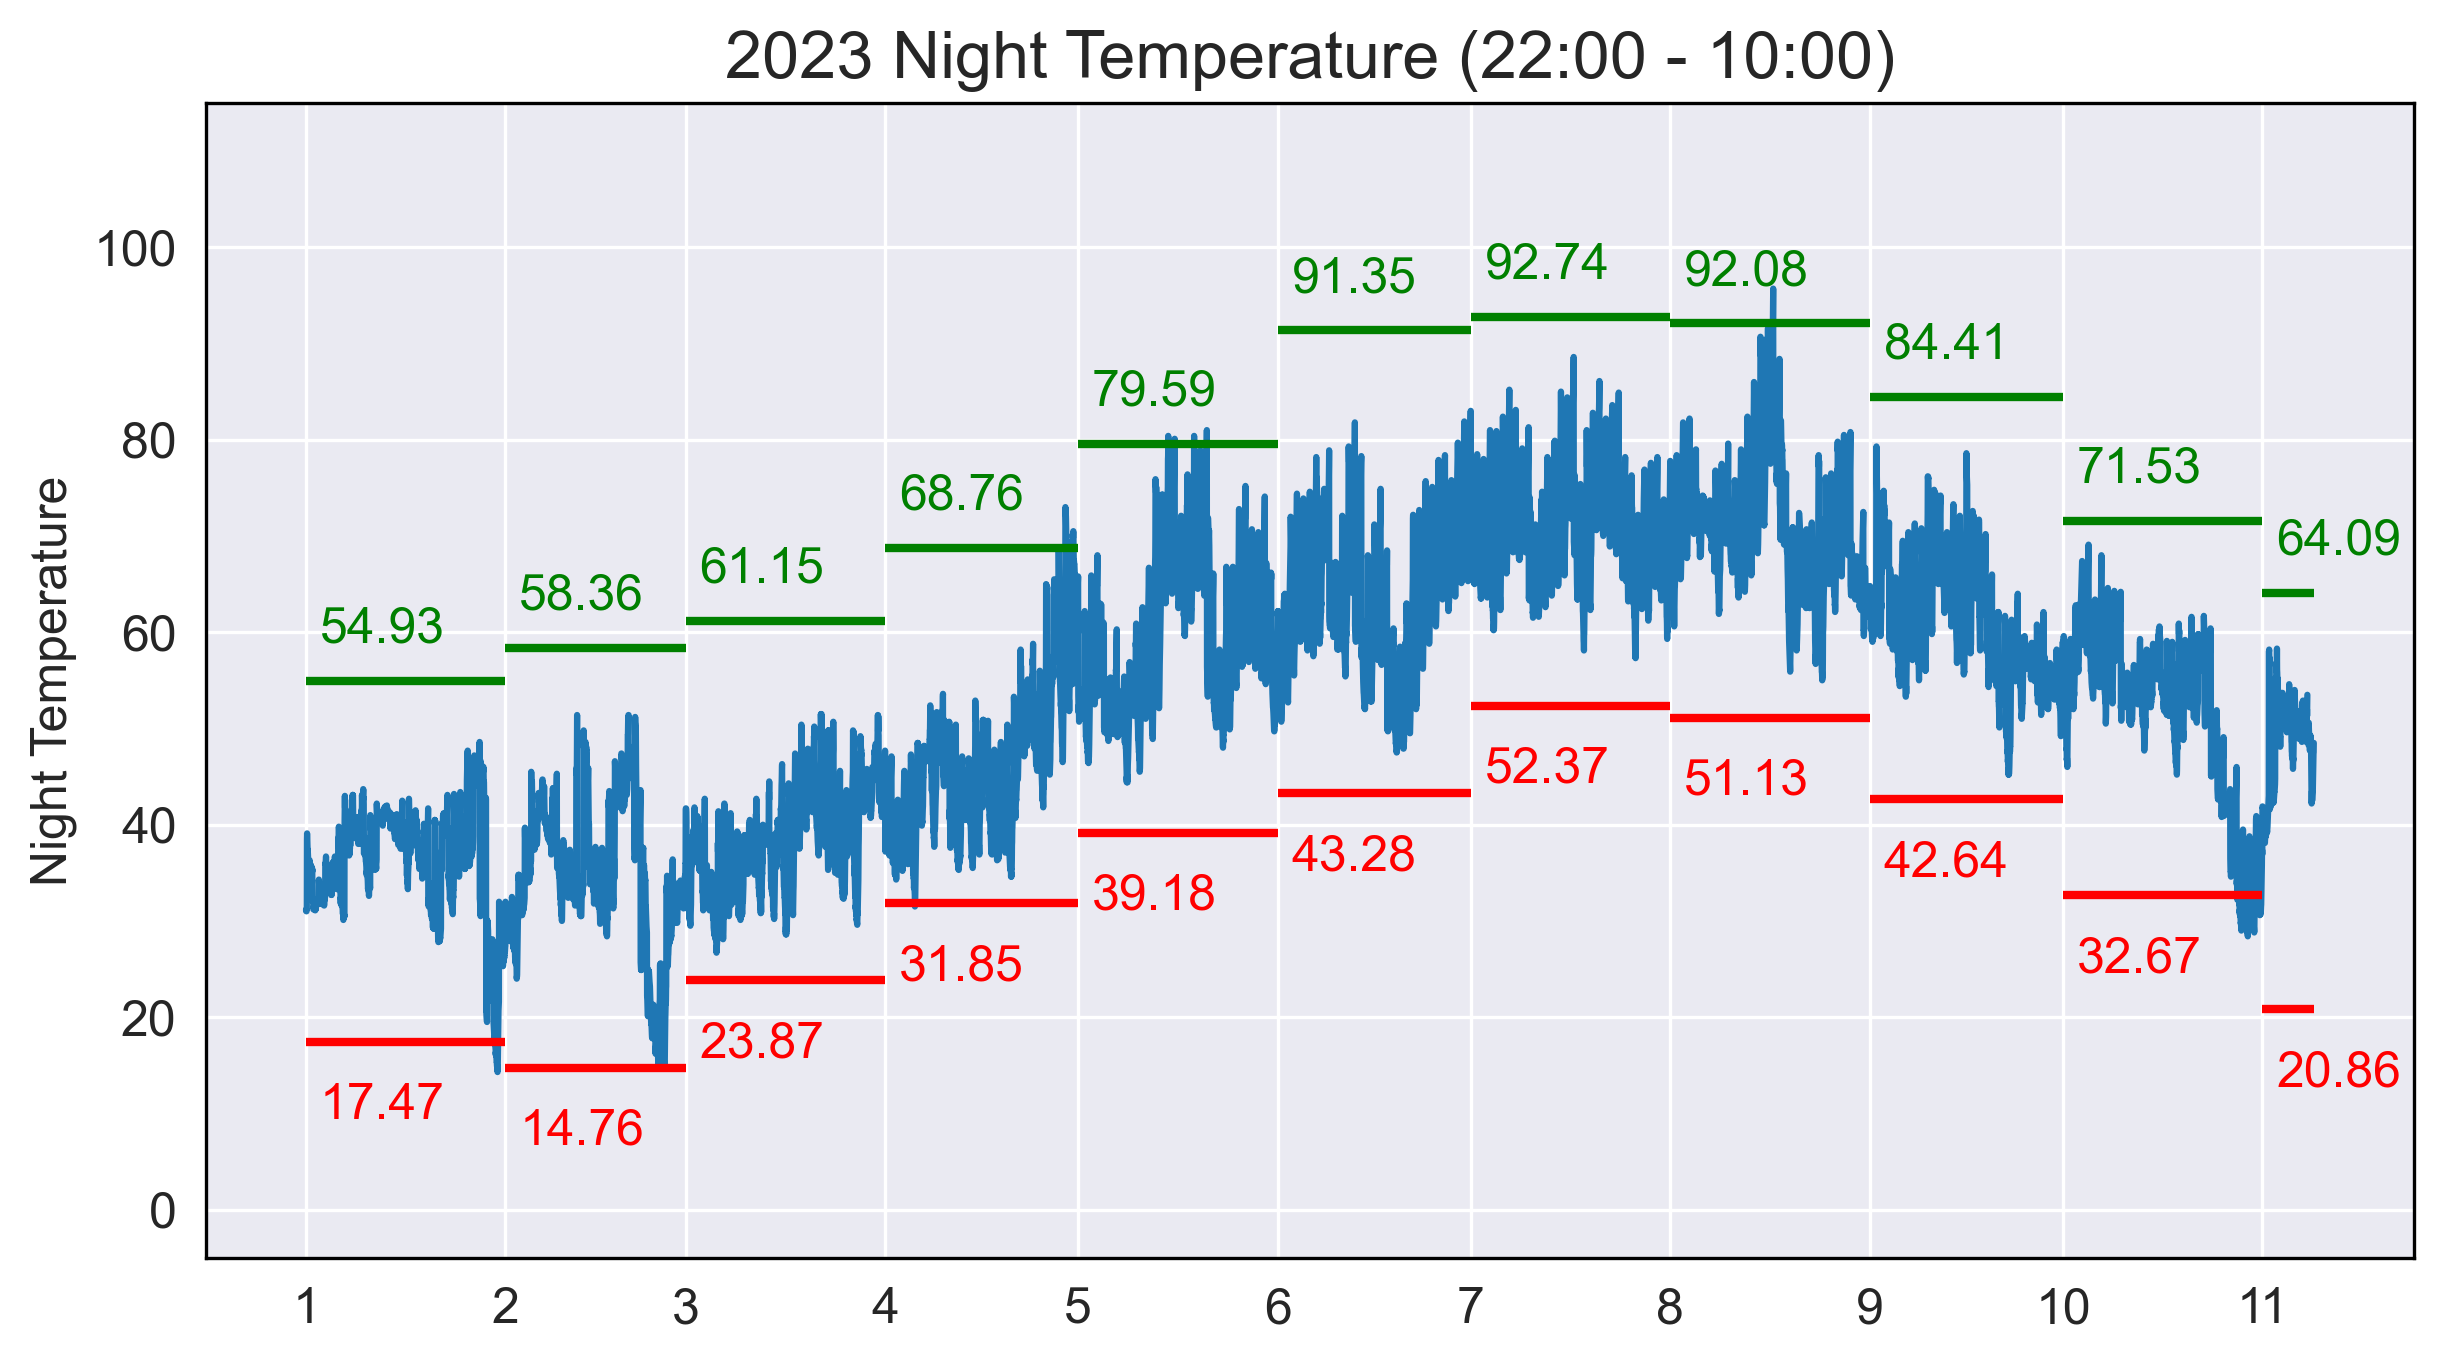

In [169]:
n_std = 1 # set number of standard dev (this is more of just a threshold)

# Get low and high temp bounds for each month (12 values)
low_bounds = np.round(monthly_min_night_est - n_std * monthly_min_night_std, 2)
high_bounds = np.round(monthly_max_night_est + n_std * monthly_max_night_std, 2)

# Create plot for single month
plt.figure(figsize=(9.5,5))
plt.plot(s87_pivot_v_night.values.flatten())
plt.title('2023 Night Temperature (22:00 - 10:00)')
plt.ylabel('Night Temperature')
for i in range(1, len(m_idx)):
    plt.hlines(low_bounds[i-1], m_idx[i-1], m_idx[i], color='r', linestyle='solid', linewidth=2)
    plt.hlines(high_bounds[i-1], m_idx[i-1], m_idx[i], color='g', linestyle='solid', linewidth=2)
    plt.text(m_idx[i-1]+100, low_bounds[i-1]-8, str(low_bounds[i-1]), color='r')
    plt.text(m_idx[i-1]+100, high_bounds[i-1]+4, str(high_bounds[i-1]), color='g')
plt.ylim(-5, 115)
plt.xticks(m_idx[:-1], range(1,12))

plt.show();

If we look at day and night cycles for estimating the parameters, we can see a slight difference in the estimated parameters based on the time of day. Night temperatures are slightly slower, mainly during summer the max is ~18 degrees lower. The night slightly shifts the bounds down for both min/max, but is broken down further in the table below to see the difference.

- **NOTE: these bounds do vary depending on the time frame chosen. Currently, they are what are defined by the QC check.**

In [183]:
# Calculate estimated high and low temps for day/night (same as graph)
d_low = np.round(monthly_min_day_est - n_std * monthly_min_day_std, 2)
d_high = np.round(monthly_max_day_est + n_std * monthly_max_day_std, 2)
n_low = np.round(monthly_min_night_est - n_std * monthly_min_night_std, 2)
n_high = np.round(monthly_max_night_est + n_std * monthly_max_night_std, 2)

pd.DataFrame(data={
    "Month": range(1,13),
    "Day Min": d_low,
    "Night Min": n_low,
    "Min Temp Diff": d_low - n_low,
    "Day Max": d_high,
    "Night Max": n_high,
    "Max Temp Diff": d_high - n_high,
})


,Month,Day Min,Night Min,Min Temp Diff,Day Max,Night Max,Max Temp Diff
0,1,20.05,17.47,2.58,58.69,54.93,3.76
1,2,19.12,14.76,4.36,65.24,58.36,6.88
2,3,29.37,23.87,5.50,72.19,61.15,11.04
3,4,37.42,31.85,5.57,80.91,68.76,12.15
4,5,43.35,39.18,4.17,94.16,79.59,14.57
5,6,46.89,43.28,3.61,104.88,91.35,13.53
6,7,58.12,52.37,5.75,109.79,92.74,17.05
7,8,58.41,51.13,7.28,108.69,92.08,16.61
8,9,49.33,42.64,6.69,99.30,84.41,14.89
9,10,38.23,32.67,5.56,83.88,71.53,12.35


In the table, the following is calculated ($+$ means day bound is high, $-$ means day bound is lower):
- *Min Temp Diff*: this is the difference between the day and night minimum temperature .
- *Max Temp Diff*: this is the difference between the day and night maximum temperature.

### Daily Bounds Estimation

In [16]:
# Split pivot table into estimation and validation
s87_pivot_e = s87_pivot.iloc[:3287, :] # pull all data from 2014 - 2022
s87_pivot_v = s87_pivot.iloc[3287:, :] # pull all data from 2023 - end

In [17]:
q_val = 0.99

# create dataframe
df = pd.DataFrame({
    "month_day": [x.split('-', 1)[1] for x in s87_pivot_e.index.values], # get month and day, "MM-DD"
    "year": [x.split('-', 1)[0] for x in s87_pivot_e.index.values], # get year, "YYYY"
    "daily_min": s87_pivot_e.quantile(q = 1-q_val, axis=1).values, # get value that has q_val percent above
    "daily_max": s87_pivot_e.quantile(q = q_val,axis=1).values, # get value that has q_val percent below
    "daily_avg": np.round(s87_pivot_e.mean(axis=1, skipna=True).values, 1), # get daily average (not used)
})

In [18]:
# We can access January 1st for every year by using the month_day column
# -> Use this to group by, then take average
df.loc[df.month_day == '01-01']

,month_day,year,daily_min,daily_max,daily_avg
0,01-01,2014,31.095,38.305,34.3
365,01-01,2015,15.190,26.800,20.9
730,01-01,2016,22.790,25.300,24.2
1096,01-01,2017,25.550,37.220,31.7
1461,01-01,2018,29.090,33.400,31.6
1826,01-01,2019,28.100,38.040,32.4
2191,01-01,2020,45.465,53.305,48.8
2557,01-01,2021,39.495,45.260,42.0
2922,01-01,2022,8.085,21.120,13.6


In [19]:
# Group by month_day, then take min/max/mean of corresponding
est = df.groupby('month_day').agg({'daily_min': 'min', 'daily_max': 'max', 'daily_avg': 'mean'})

est # 366 values (includes leap year estimate)

,daily_min,daily_max,daily_avg
month_day,,,
01-01,8.085,53.305,31.055556
01-02,14.200,52.800,31.133333
01-03,14.595,54.205,33.877778
01-04,13.380,51.100,34.011111
01-05,8.790,55.225,34.411111
...,...,...,...
12-27,18.800,52.720,34.466667
12-28,20.300,49.400,34.944444
12-29,17.090,53.810,34.144444


In [20]:
# Group by month_day, then take standard deviation of min/max/avg daily values
std = df.groupby('month_day')[['daily_min', 'daily_max', 'daily_avg']].std()

std # 366 values (includes leap year estimate)

,daily_min,daily_max,daily_avg
month_day,,,
01-01,11.380487,10.126793,10.621454
01-02,9.612886,12.313653,10.068764
01-03,9.442540,11.227117,9.543948
01-04,8.844501,9.296913,8.285597
01-05,8.733923,9.577245,9.578550
...,...,...,...
12-27,5.249587,8.032340,6.579324
12-28,5.232384,7.900589,6.278358
12-29,6.023914,8.742964,7.070557


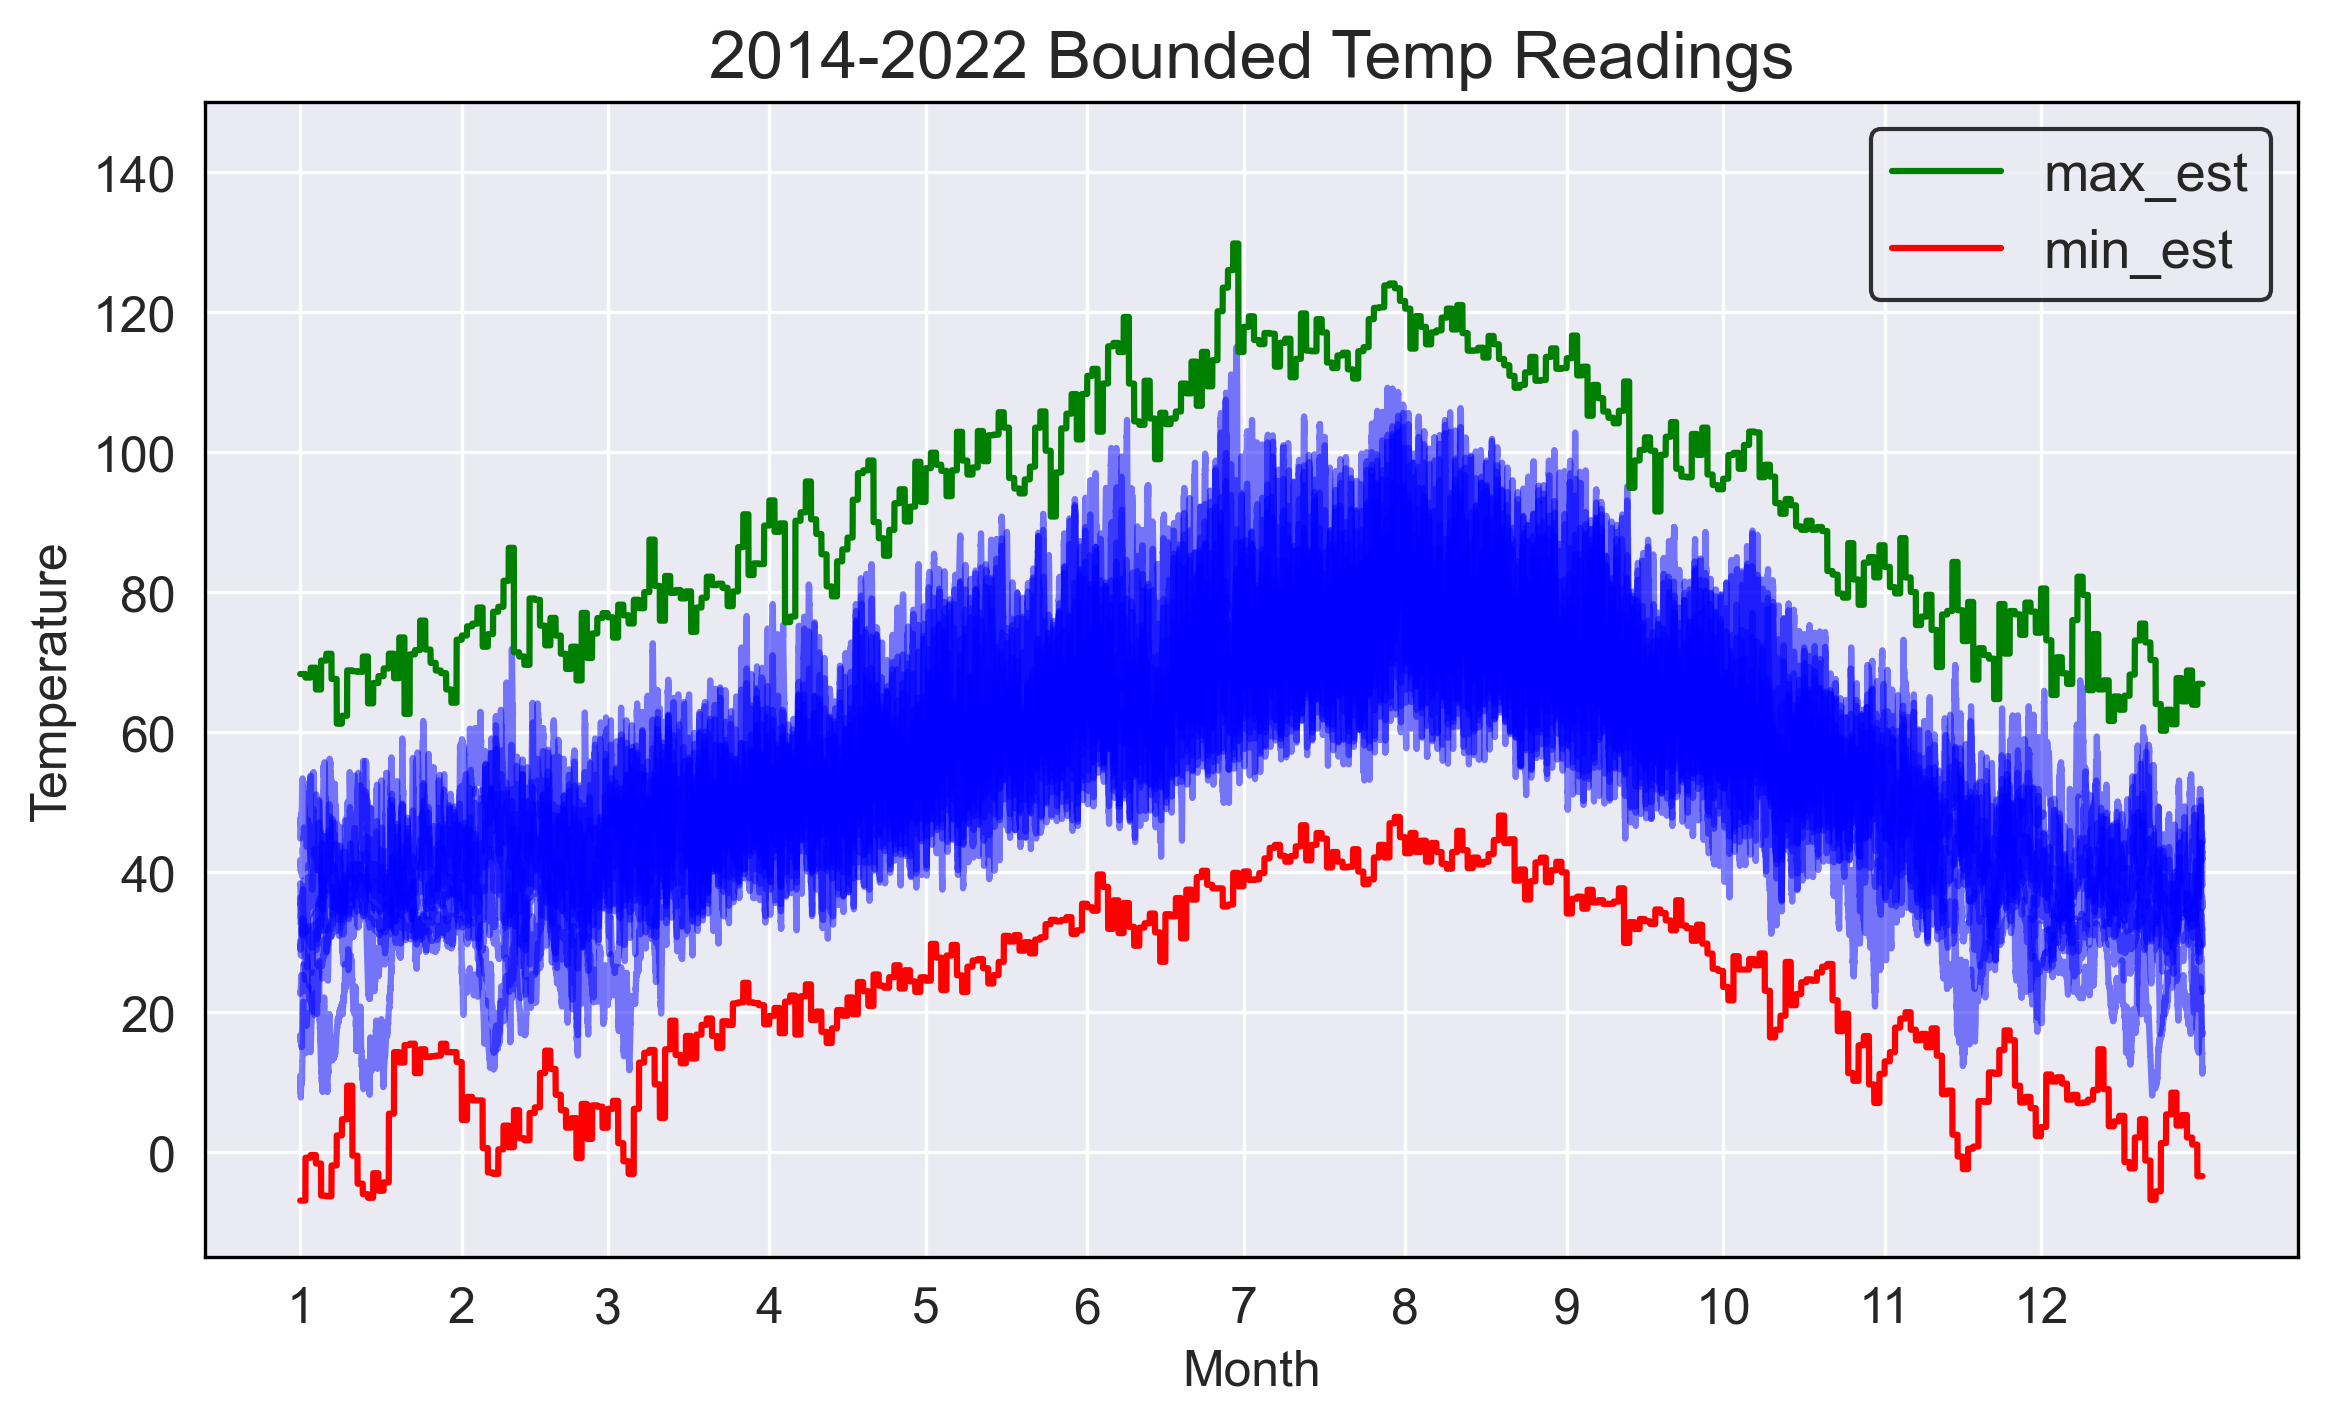

In [21]:
# Create copy of each data frame
all_e = s87_pivot_e.copy()
est_b = est.copy()
std_b = std.copy()

all_e['year'] = [x.split('-')[0] for x in all_e.index.values] # get years

# drop leap year observations (only 2 occurances)
all_e.drop([x for x in all_e.index.values if "02-29" in x], inplace=True)
est_b.drop([x for x in est_b.index.values if "02-29" in x], inplace=True)
std_b.drop([x for x in std_b.index.values if "02-29" in x], inplace=True)

# Each day has 96 readings (repeat bounds 96 times since plot has all data)
min_est = np.repeat(est_b.daily_min.values, 96)
max_est = np.repeat(est_b.daily_max.values, 96)
avg_est = np.repeat(est_b.daily_avg.values, 96)

min_std = np.repeat(std_b.daily_min.values, 96)
max_std = np.repeat(std_b.daily_max.values, 96)
avg_std = np.repeat(std_b.daily_avg.values, 96)

# Estimate bounds
n_std = 1.2
high_bound = max_est + 15 # + n_std*max_std
low_bound = min_est - 15 # - n_std*min_std

plt.figure(figsize=(9,5))

for y in all_e.year.unique(): # iterate over each year
    tmp = all_e[all_e.year == y] # subset year
    tmp = tmp.drop(columns=['year']) # drop year column
    vals = tmp.values.flatten() # get all temp readings
    plt.plot(vals, alpha=0.5, color='b') # plot in same color
    
d = [int(x.split('-')[1]) for x in tmp.index.values] # get month from index
m_idx = [x*len(tmp.columns.tolist()) for x in range(1,len(d)) if d[x] != d[x-1]] # find where month changes
m_idx.insert(0, 0) # insert start date
    
plt.plot(high_bound, color='green', label='max_est')
plt.plot(low_bound, color='red', label='min_est')
plt.title('2014-2022 Bounded Temp Readings')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.ylim(-15, 150)
plt.xticks(m_idx, range(1,13))
plt.legend()

plt.show();

In [22]:
# Find values of index to pull from estimates to be plotted for 2023
# -> This filters out leap year (if not used) and December (since not in 2023 data)
v_idx = [x.split('-', 1)[1] for x in s87_pivot_v.index.values]

est_2023 = est.loc[v_idx] # subset estimates with only 2023 available dates
std_2023 = std.loc[v_idx] # subset std dev with only 2023 available dates

In [23]:
# Each day has 96 readings (repeat bounds 96 times since plot has all data)
min_est = np.repeat(est_2023.daily_min.values, 96)
max_est = np.repeat(est_2023.daily_max.values, 96)
avg_est = np.repeat(est_2023.daily_avg.values, 96)

min_std = np.repeat(std_2023.daily_min.values, 96)
max_std = np.repeat(std_2023.daily_max.values, 96)
avg_std = np.repeat(std_2023.daily_avg.values, 96)

In [24]:
tmp = [int(x.split('-')[1]) for x in s87_pivot_v.index.values] # get month from index
m_idx = [x*len(s87_pivot_v.columns.tolist()) for x in range(1,len(tmp)) if tmp[x] != tmp[x-1]] # find where month changes
m_idx.insert(0, 0) # insert start date
m_idx.append(len(s87_pivot_v.values.flatten())) # insert end date

**Using Standard Deviation (per day)**

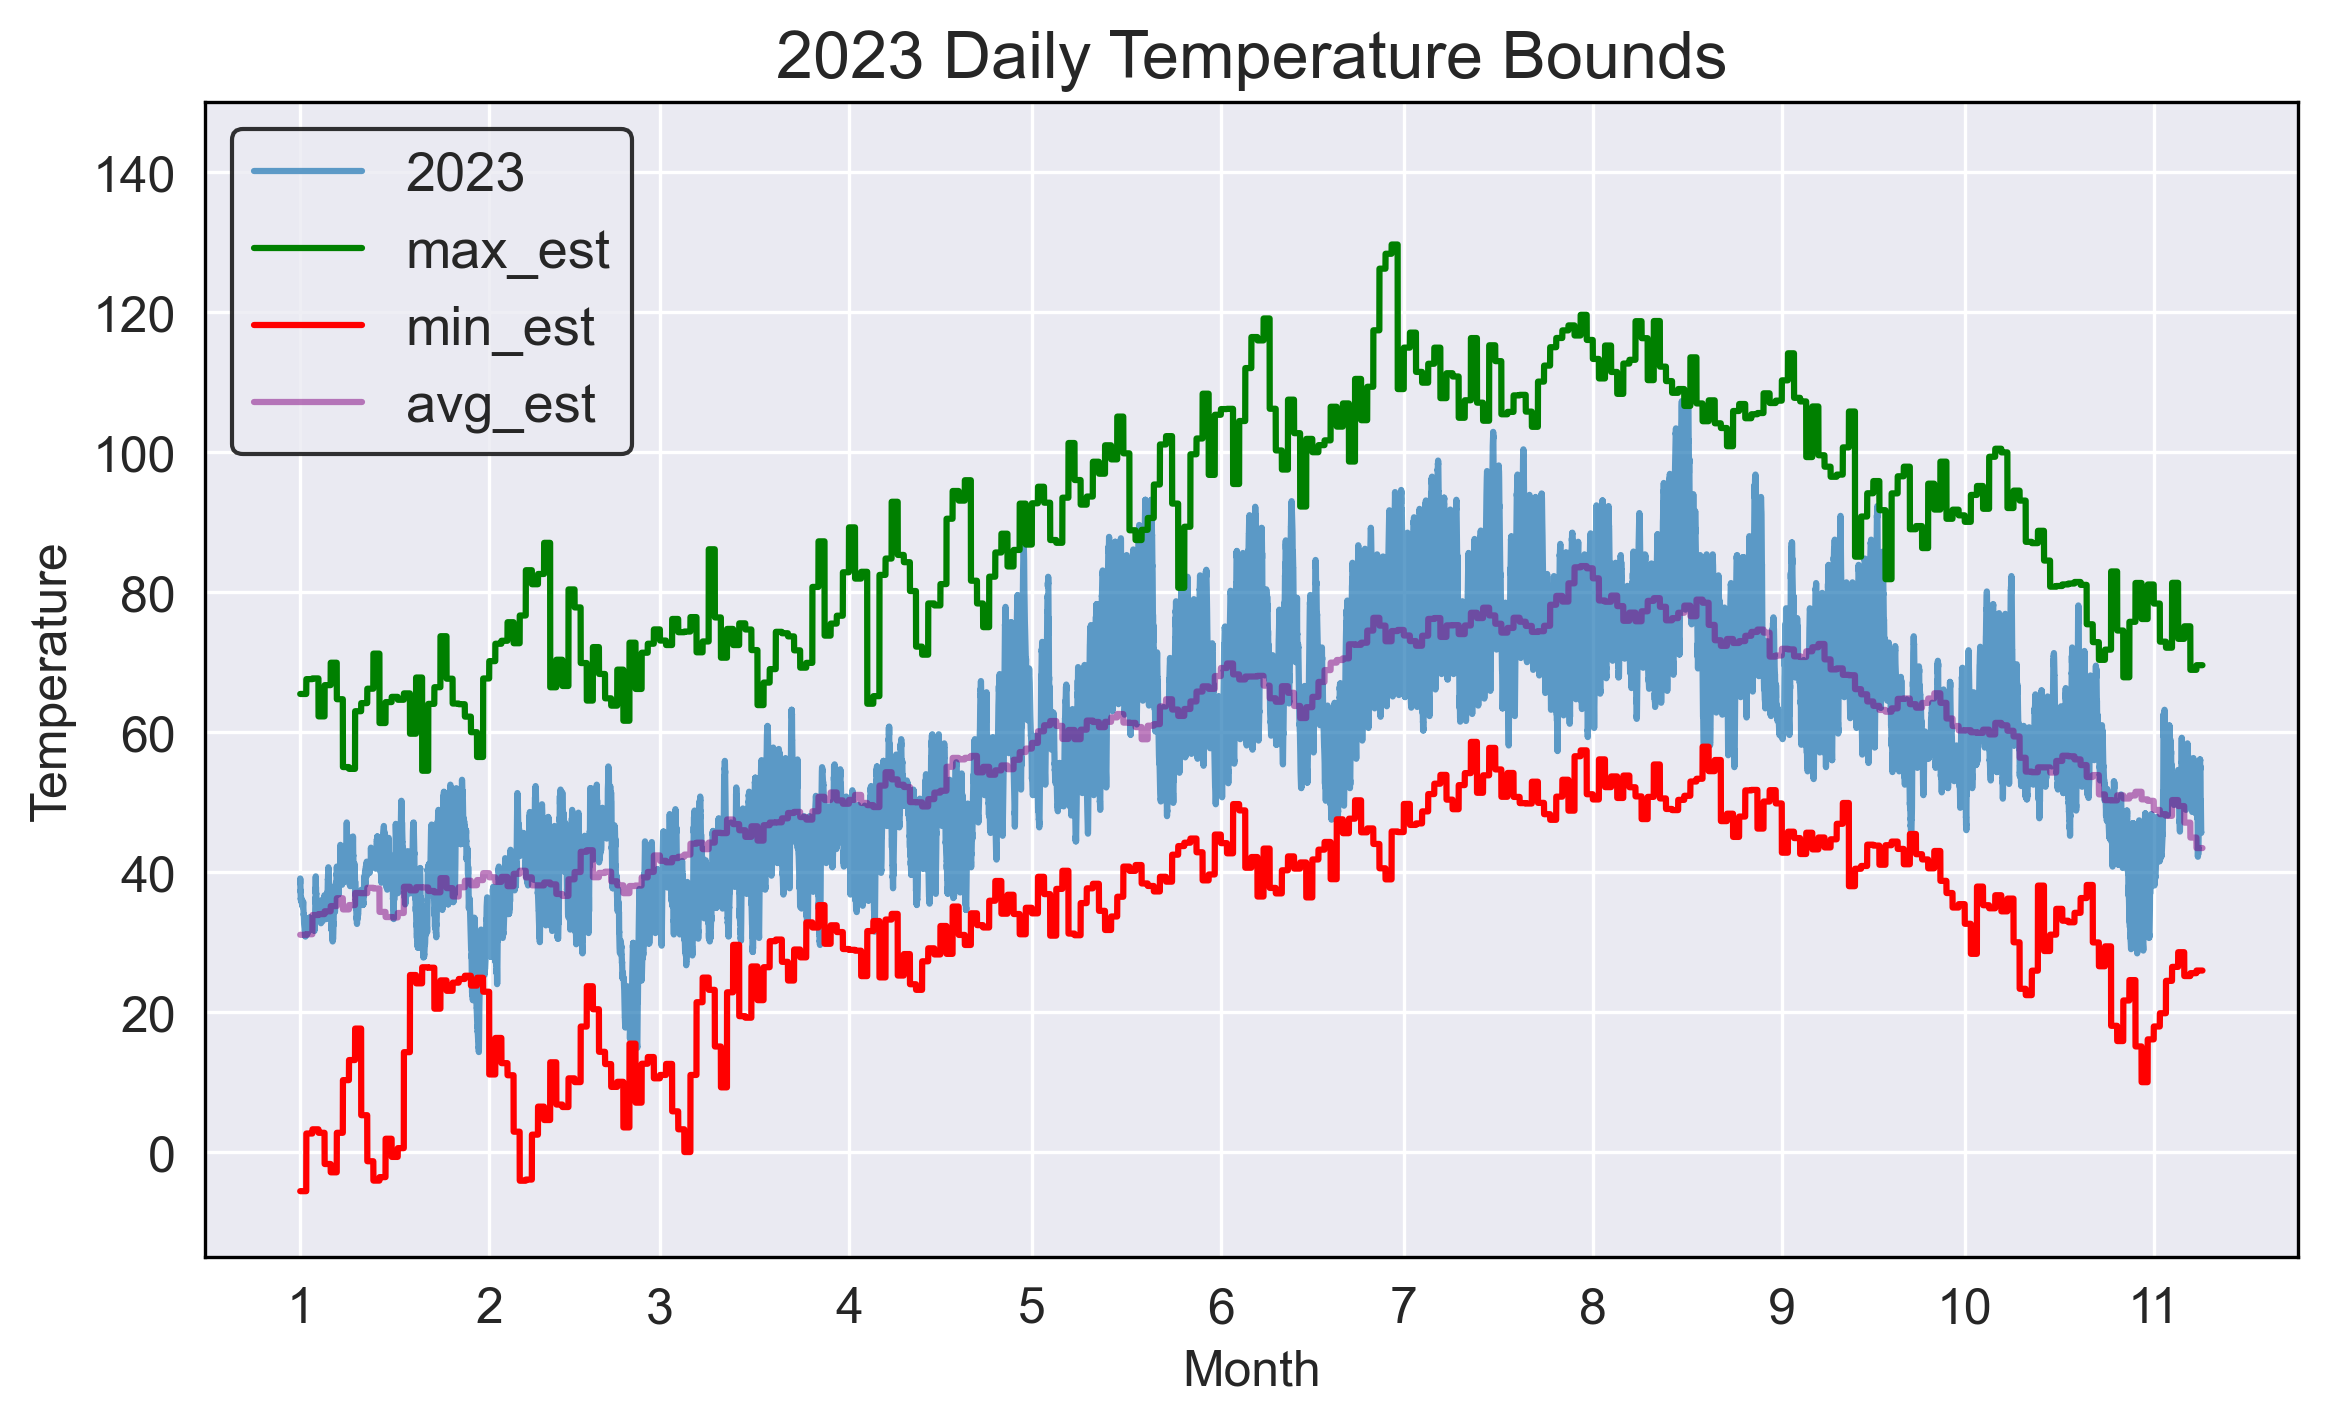

In [30]:
vals = s87_pivot_v.values.flatten()

n_std = 1.2
high_bound = max_est + n_std*max_std
low_bound = min_est - n_std*min_std

plt.figure(figsize=(9,5))
plt.plot(vals, alpha=0.7, label='2023')
plt.plot(high_bound, color='green', label='max_est')
plt.plot(low_bound, color='red', label='min_est')
plt.plot(avg_est, color='purple', alpha=0.5, label="avg_est")
plt.title('2023 Daily Temperature Bounds')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.ylim(-15, 150)
plt.xticks(m_idx[:-1], range(1,12))
plt.legend()

plt.show();

In [31]:
# Calculate what percent of readings were flagged using formulas
flagged_max = sum(vals > high_bound)/len(high_bound)
flagged_min = sum(vals < low_bound)/len(low_bound)

print(f"Too Hot Flags Raised: {sum(vals > high_bound)}/{len(high_bound)} ; {round(100 * flagged_max, 2)}%")
print(f"Too Cold Flags Raised: {sum(vals < low_bound)}/{len(low_bound)} ; {round(100 * flagged_min, 2)}%")

Too Hot Flags Raised: 55/29952 ; 0.18%
Too Cold Flags Raised: 136/29952 ; 0.45%


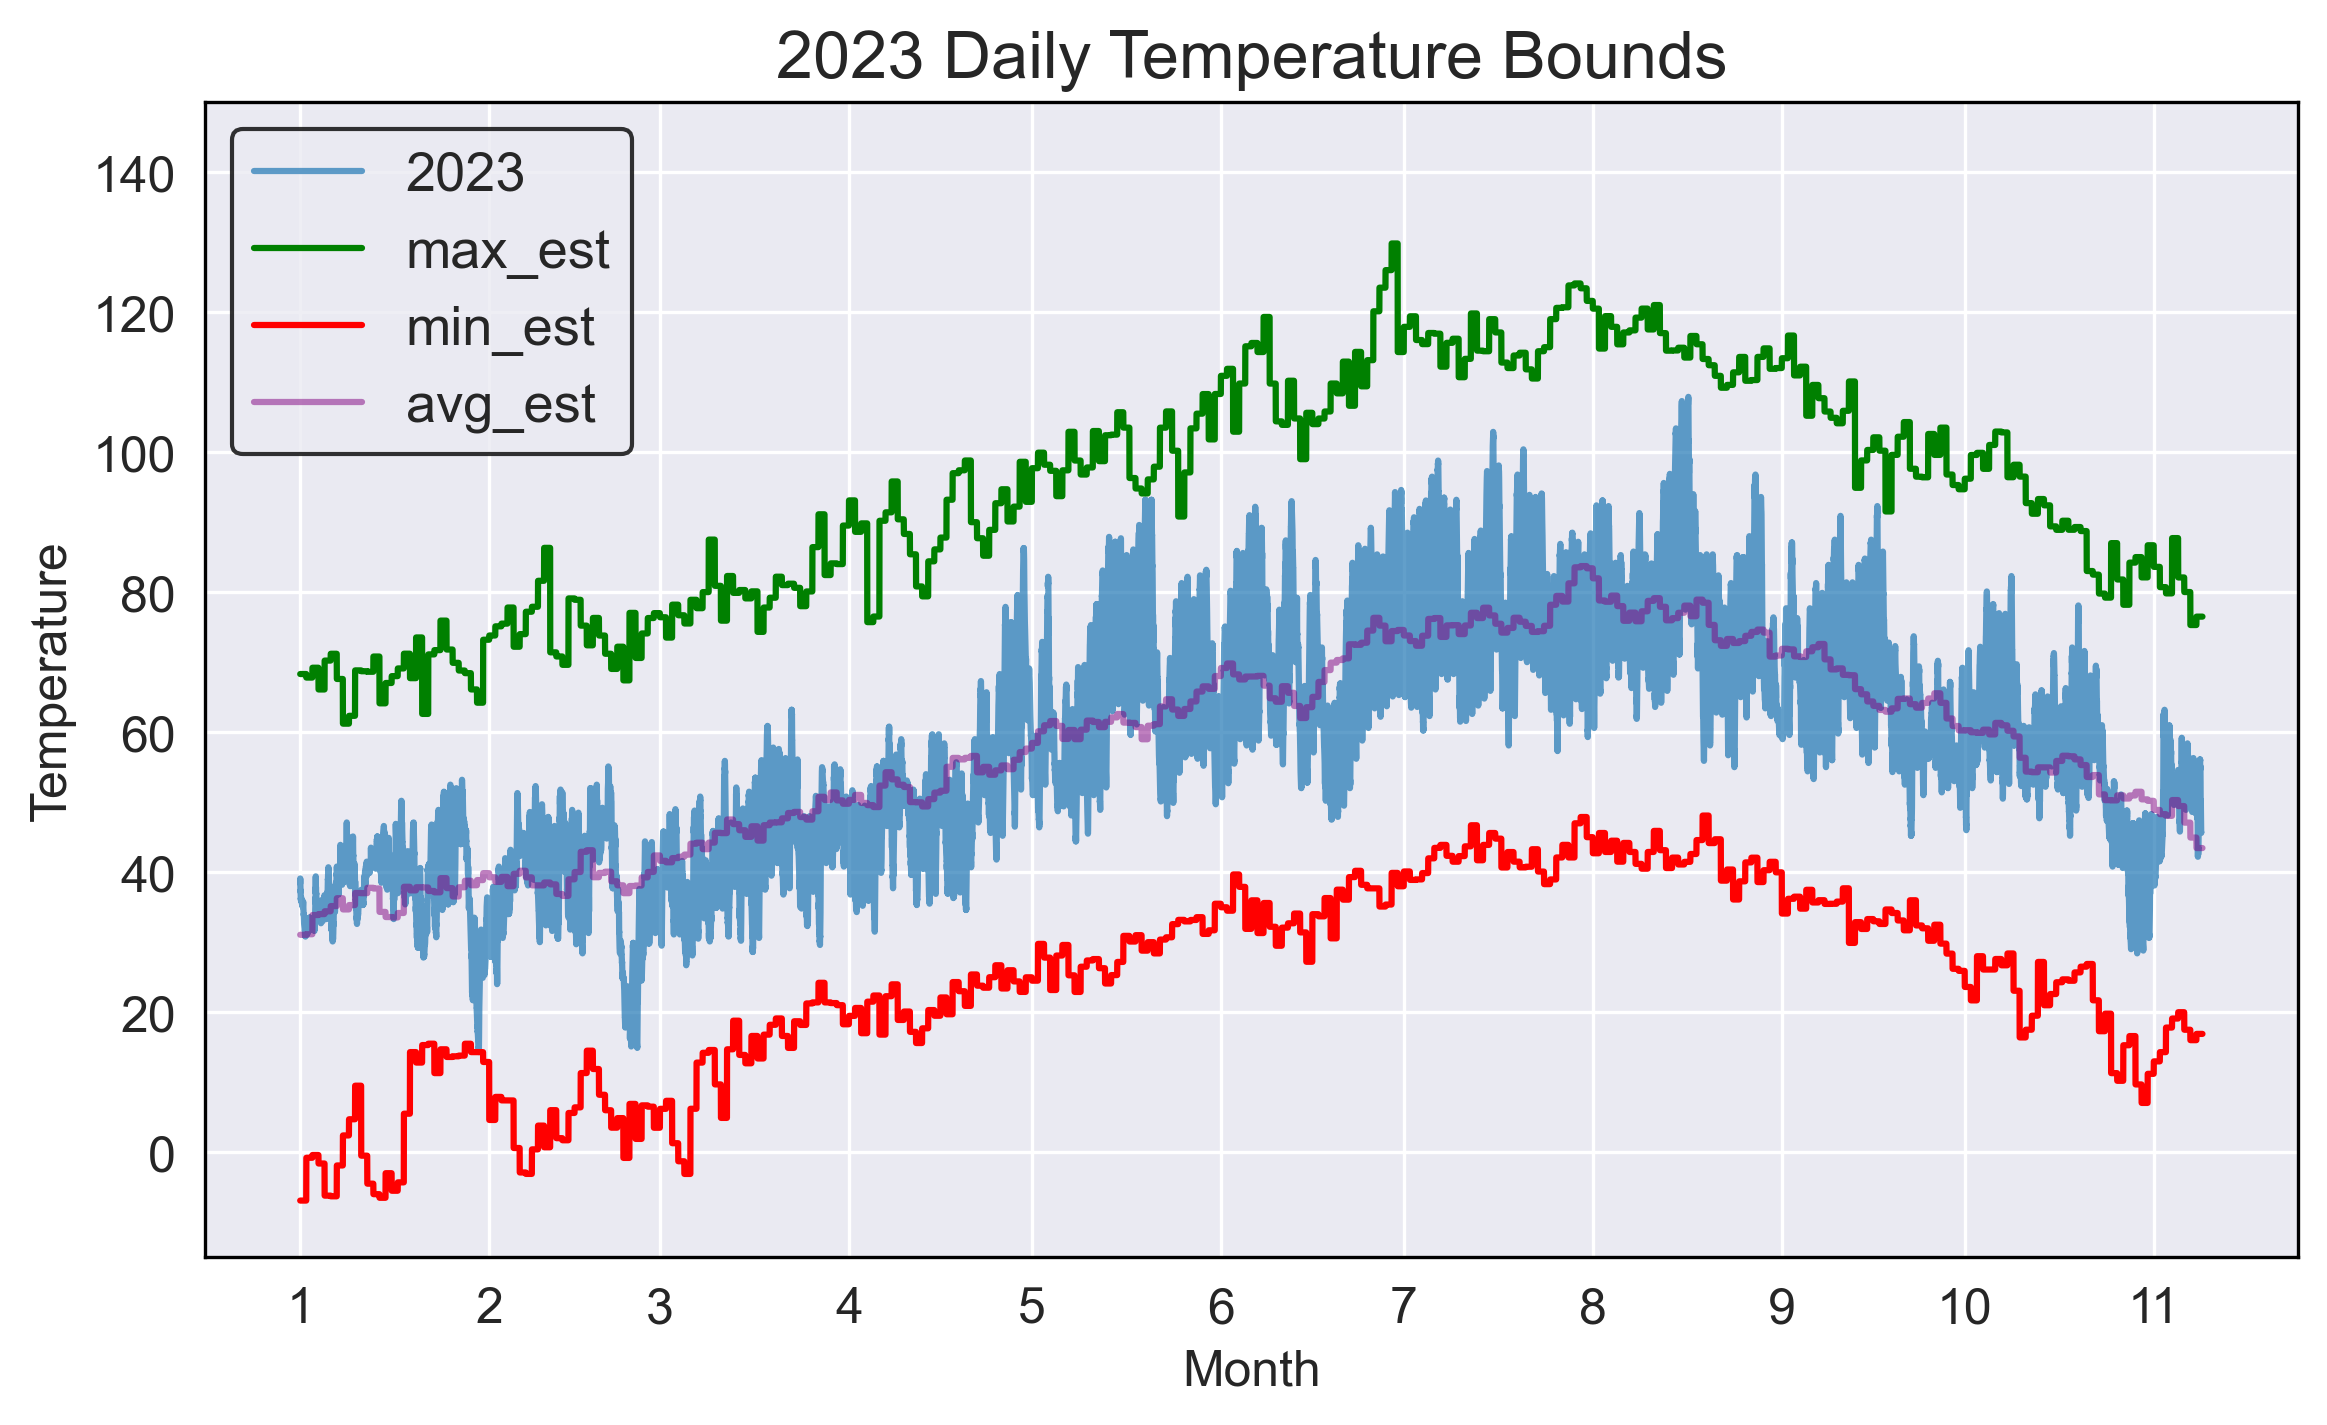

In [32]:
vals = s87_pivot_v.values.flatten()

high_bound = max_est + 15 # + n_std*max_std
low_bound = min_est - 15 # - n_std*min_std

plt.figure(figsize=(9,5))
plt.plot(vals, alpha=0.7, label='2023')
plt.plot(high_bound, color='green', label='max_est')
plt.plot(low_bound, color='red', label='min_est')
plt.plot(avg_est, color='purple', alpha=0.5, label="avg_est")
plt.title('2023 Daily Temperature Bounds')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.ylim(-15, 150)
plt.xticks(m_idx[:-1], range(1,12))
plt.legend()

plt.show();

In [33]:
# Calculate what percent of readings were flagged using formulas
flagged_max = sum(vals > high_bound)/len(high_bound)
flagged_min = sum(vals < low_bound)/len(low_bound)

print(f"Too Hot Flags Raised: {sum(vals > high_bound)}/{len(high_bound)} ; {round(100 * flagged_max, 2)}%")
print(f"Too Cold Flags Raised: {sum(vals < low_bound)}/{len(low_bound)} ; {round(100 * flagged_min, 2)}%")

Too Hot Flags Raised: 0/29952 ; 0.0%
Too Cold Flags Raised: 0/29952 ; 0.0%


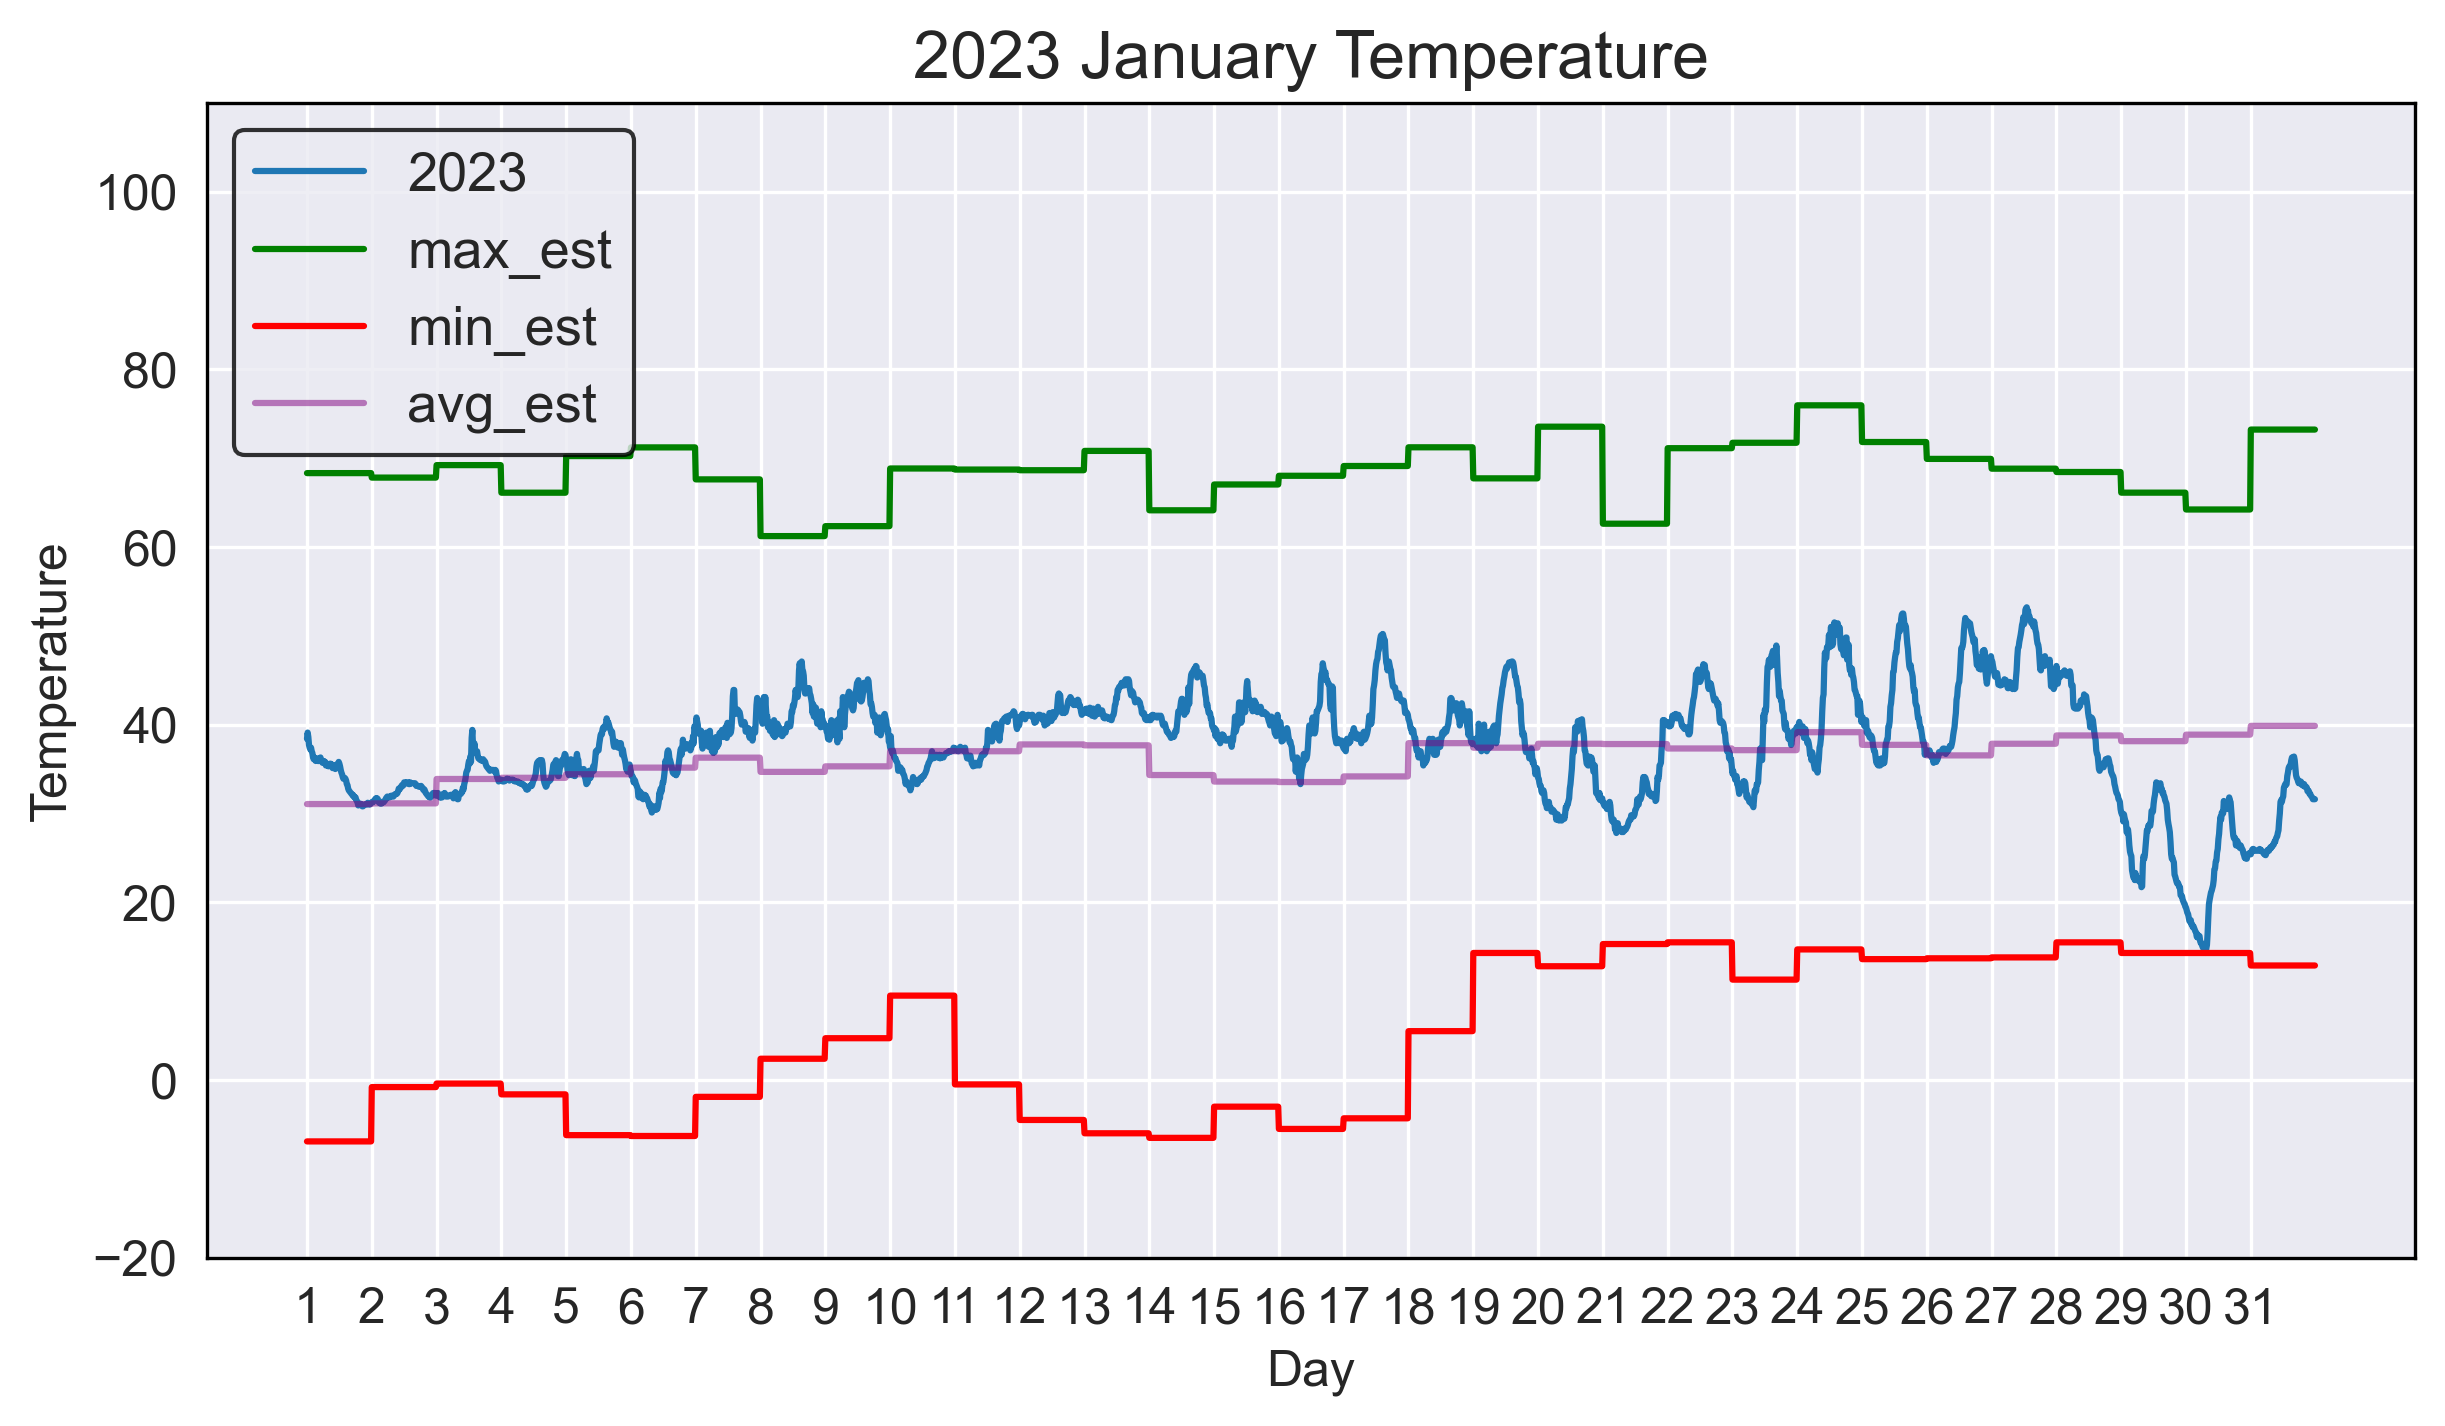

In [34]:
jan = 31*96

plt.figure(figsize=(9.5,5))
plt.plot(vals[:jan], label='2023')
plt.plot(high_bound[:jan], color='green', label='max_est')
plt.plot(low_bound[:jan], color='red', label='min_est')
plt.plot(avg_est[:jan], color='purple', alpha=0.5, label="avg_est")
plt.title('2023 January Temperature')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.ylim(-20, 110)
plt.xticks([x for x in range(0,jan) if x % 96 == 0], range(1,32))
plt.legend()

plt.show();

In [74]:
len(m_idx)

12